In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sea
import pandas as pd
import os
from astropy.io import fits
from astropy.table import Table
import img_scale
from glob import glob
from astropy.wcs import wcs
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

CO(2-1): $\lambda$ 1.3 mm / 1300 $\mu$m

Band 3 84-116 Ghz /  2600-3600 $\mu$m

In [73]:
2600 / 1300 - 1, 3600 / 1300 - 1, 1300/3E2

(1.0, 1.7692307692307692, 4.333333333333333)

In [15]:
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4SFAST = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',
                 format='ascii').to_pandas()

In [16]:
v4S['use'] = v4Scat['use_phot']
v4S['star'] = v4Scat['class_star']
v4S['lmass'] = v4SFAST['lmass']

In [17]:
filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*full.png')

allSids = [int(os.path.basename(U).replace('.full.png','').split('_')[1]) for U in filesS]

Sids = np.array(list(set(allSids)))

Spresent = [U in Sids for U in v4S.id]

v4S['R2'] = Spresent

In [18]:
fileS_v1 = glob('/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/1D/FITS/*S*')
allSids_v1 = [int(os.path.basename(U).replace('.1D.fits','').split('_')[1]) for U in fileS_v1]

Sids_v1 = np.array(list(set(allSids_v1)))
Spresent_v1 = [U in Sids_v1 for U in v4S.id]
v4S['R1'] = Spresent_v1

In [9]:
3 < 4 and v4S.R2[0] or v4S.R1[0]

False

[0, 2.5, 0.5, 2.5]

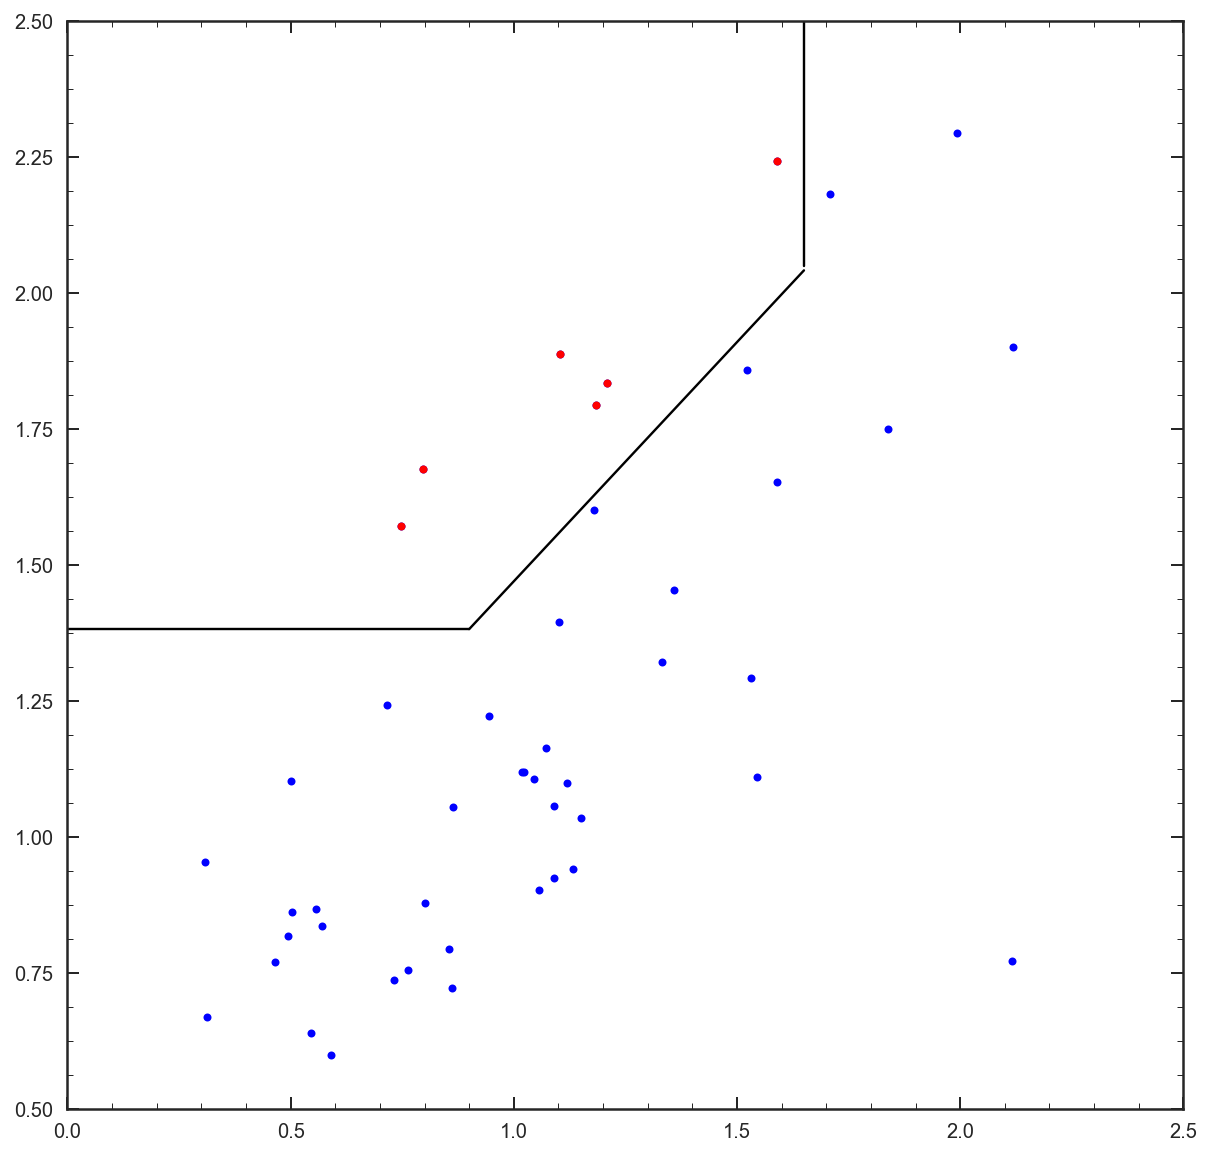

In [19]:
v4S_red = v4S.query('mass > 10**9.8 and 1.5 < z500 < 1.7 and use == 1 and star < 0.8')
v4S_red = v4S_red.query('R2 == True or R1 == True')
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

SQ = []
Ssf = []

for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)
        
plt.figure(figsize=[10,10])
plt.plot(SVJ, SUV,'bo',ms=4)

plt.plot(SVJ[SQ], SUV[SQ],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [20]:
SQ_up = np.array([26271, 29256, 38842, 39011, 39363, 40222, 41519, 42112, 42777, 43006, 44041])

In [12]:
len(v4S_red.ra[SQ_up])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


11

In [13]:
v4S.id[SQ_up].values, v4S.ra[SQ_up].values, v4S.dec[SQ_up].values, 

(array([26272, 29257, 38843, 39012, 39364, 40223, 41520, 42113, 42778,
        43007, 44042]),
 array([53.150826, 53.147471, 53.107039, 53.06424 , 53.062821, 53.124956,
        53.152726, 53.151174, 53.149594, 53.146974, 53.10457 ]),
 array([-27.790601, -27.777637, -27.729749, -27.727621, -27.726461,
        -27.722957, -27.716251, -27.713724, -27.711374, -27.709766,
        -27.705421]))

In [14]:
sflts = glob(hpath + 'Clear_data/s_flt_files/*')

dat = fits.open(sflts[0])

dat[0].header['TARGNAME']

def flt_pos(fn):
    flt=fits.open(fn)
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    pos=w.wcs_pix2world([[0,0],[xpixlim, 0],[xpixlim, ypixlim],[0, ypixlim]],1)
            
    return pos

allpos = np.zeros([len(sflts),2,5])

for i in range(len(sflts)):
    p1,p2,p3,p4 = flt_pos(sflts[i])
    allpos[i] = np.array([p1,p2,p3,p4,p1]).T
#     plt.plot(allpos[0],allpos[1], 'k',alpha = 0.1,zorder=1)

# plt.scatter(v4S.ra[SQ_up],v4S.dec[SQ_up],marker='*', s=200, color = 'r')

## img pull

In [13]:
seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data
f140 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F140W_orig_sci.fits')[0].data
f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].data
f105 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits')[0].data

In [62]:
v4S.id[SQ_up].values

array([26272, 29257, 38843, 39012, 39364, 40223, 41520, 42113, 42778,
       43007, 44042])

img_scale : asinh
img_scale : asinh
img_scale : asinh


Text(0.5,1,'Blue = F105W, Green = F125W, Red = F160W, GSD-26272')

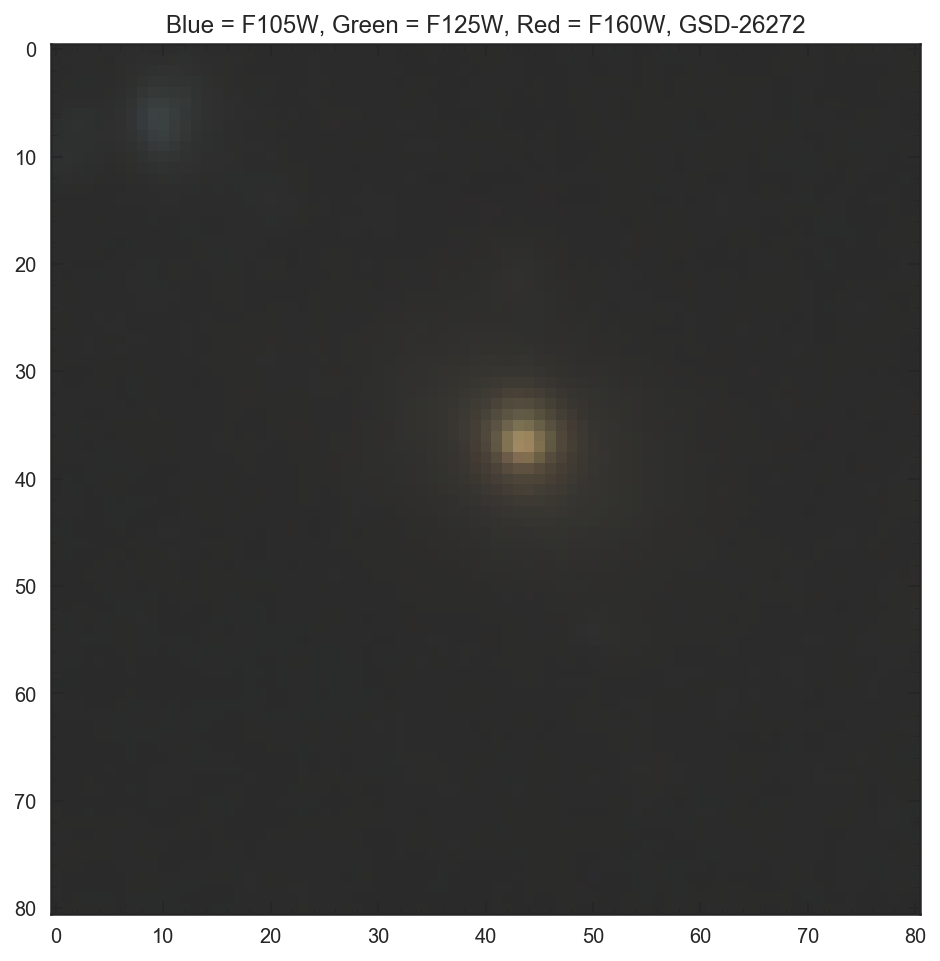

In [63]:
gids = v4S.id[SQ_up].values

i =gids[0]
# for i in gids:
idx = np.argwhere(seg == i)

ycnt =int((max(idx.T[0]) + min(idx.T[0])) / 2)
xcnt = int((max(idx.T[1]) + min(idx.T[1])) / 2)

f105img = f105[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
f125img = f125[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
f160img = f160[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]

img = np.zeros((f125img.shape[0], f125img.shape[1], 3), dtype=float)
img[:,:,0] = img_scale.asinh(f160img, scale_min=-0.1, scale_max=0.5)
img[:,:,1] = img_scale.asinh(f125img, scale_min=-0.1, scale_max=0.5)
img[:,:,2] = img_scale.asinh(f105img, scale_min=-0.1, scale_max=0.5)

plt.figure(figsize=[8,8])
plt.imshow(img,aspect='equal')
plt.title('Blue = F105W, Green = F125W, Red = F160W, GSD-{0}'.format(i))

In [42]:
np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)[34]

11469

img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh


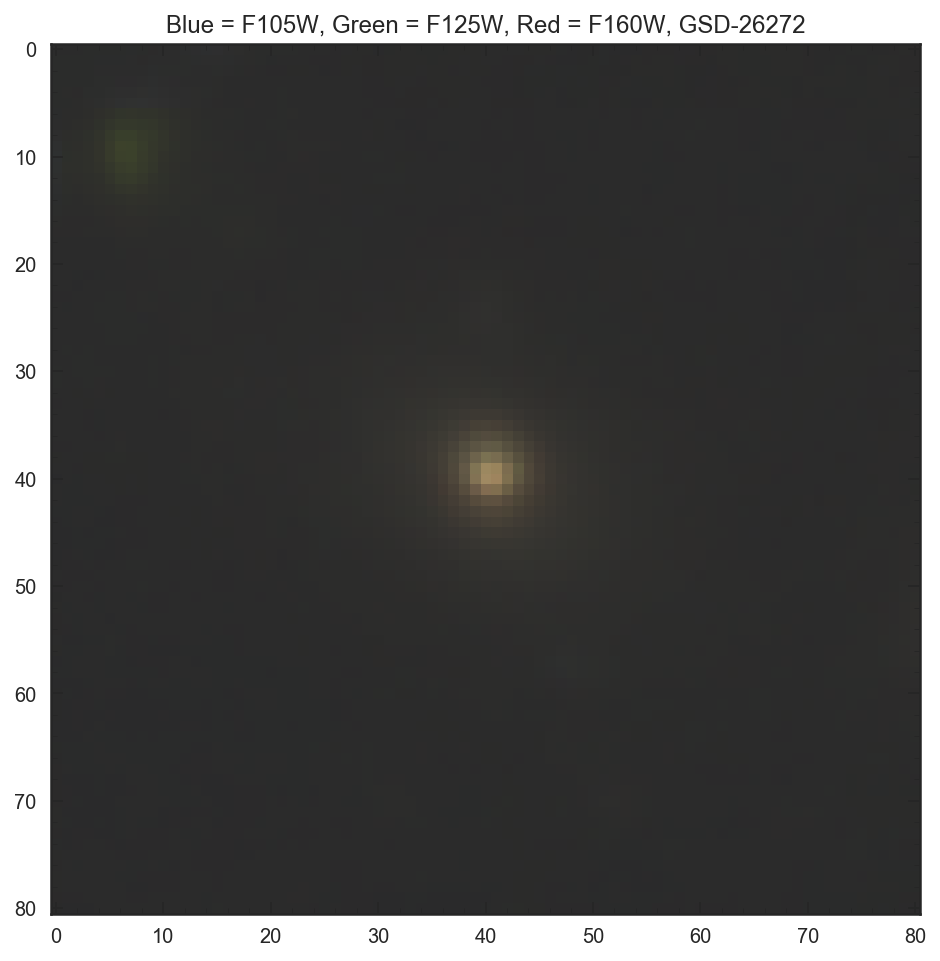

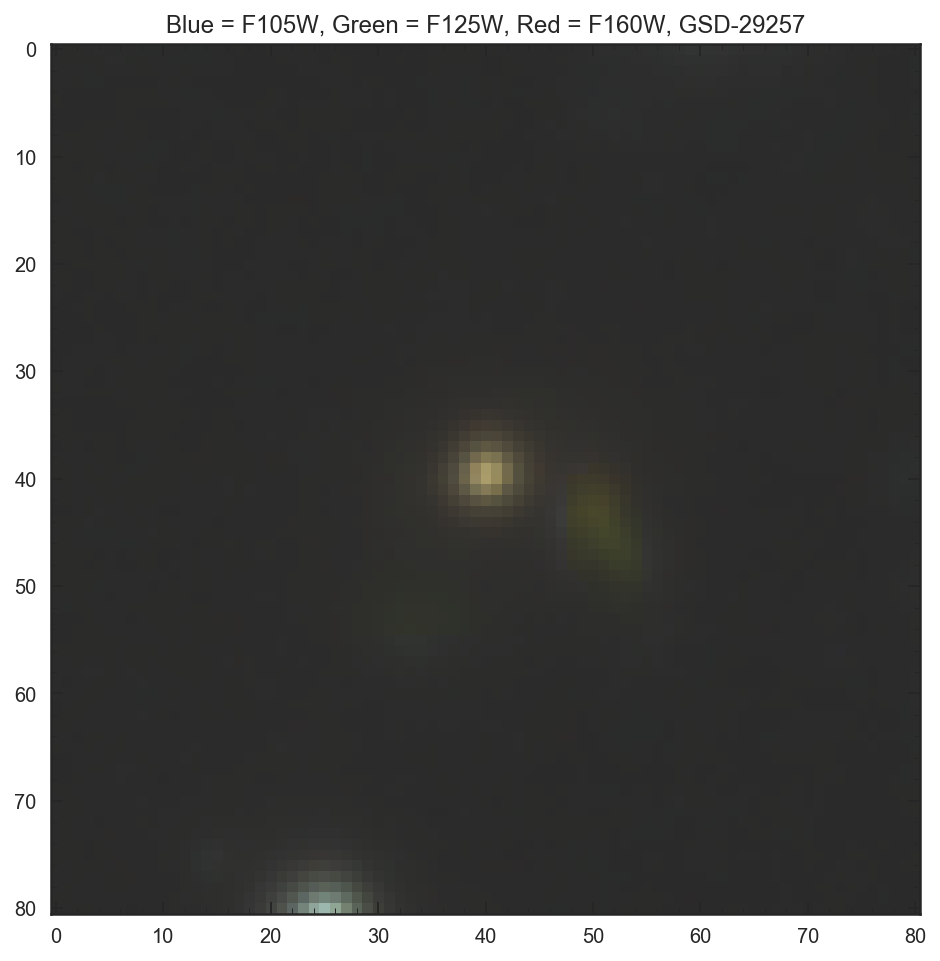

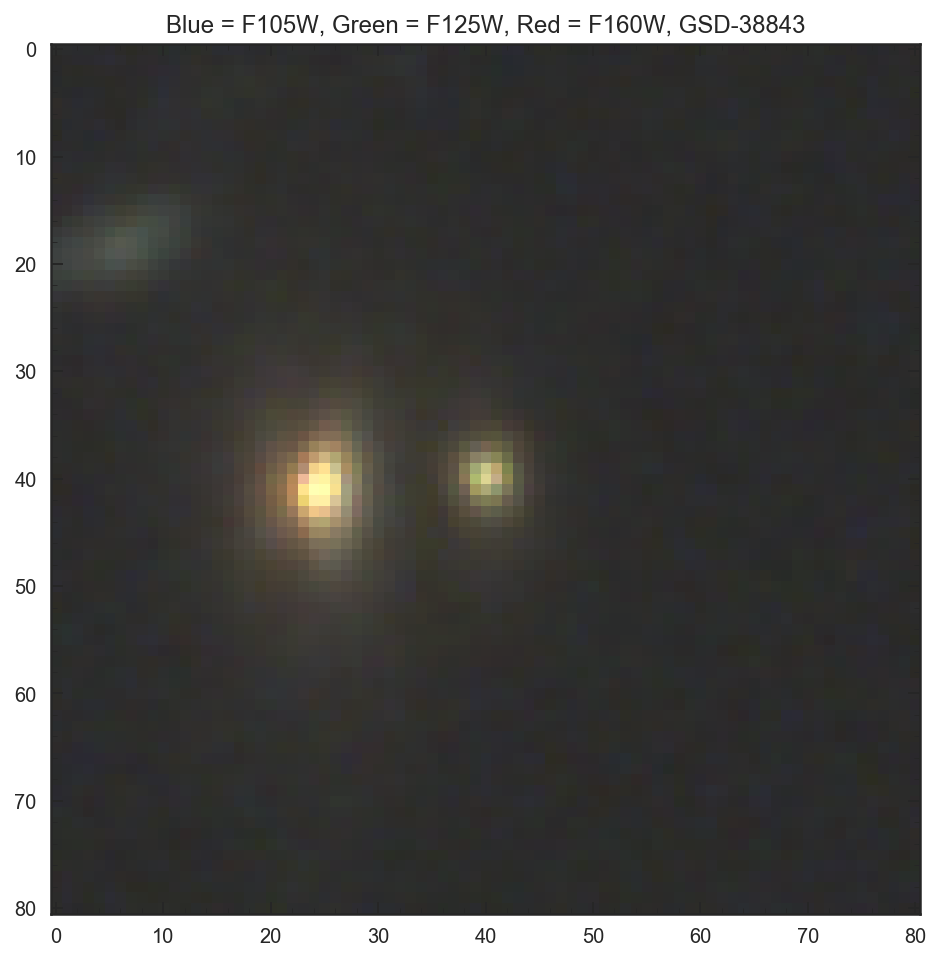

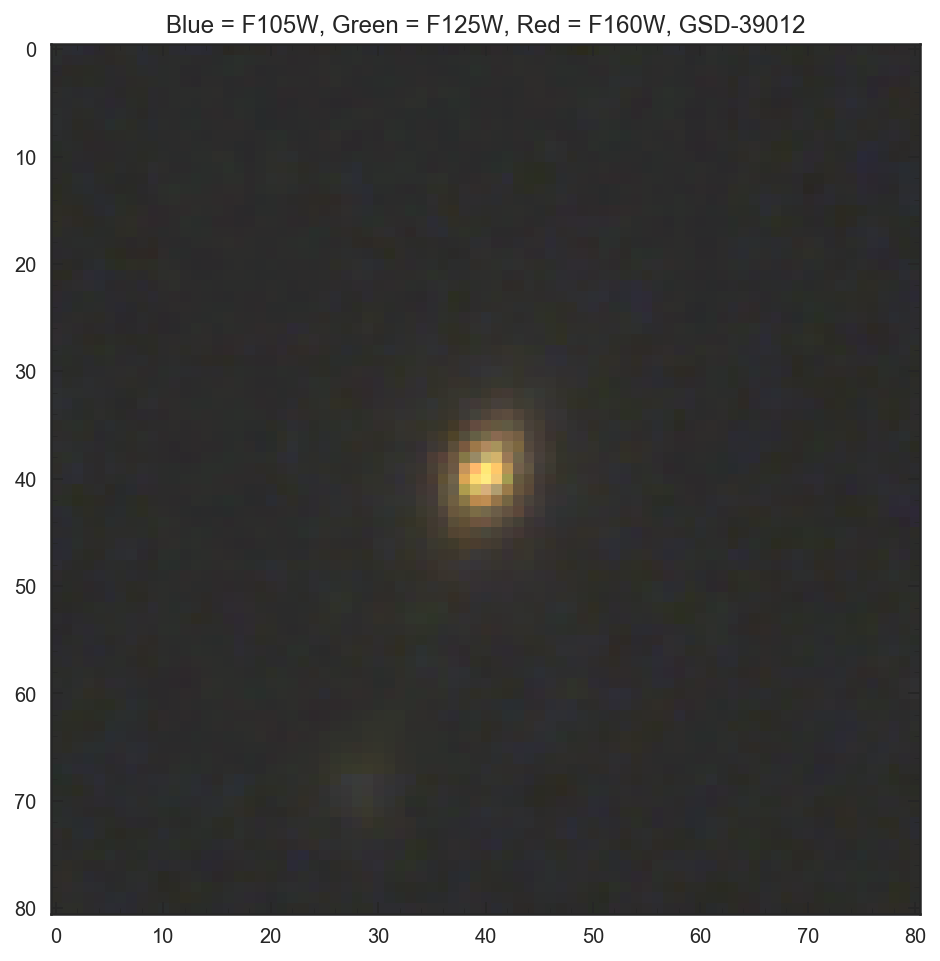

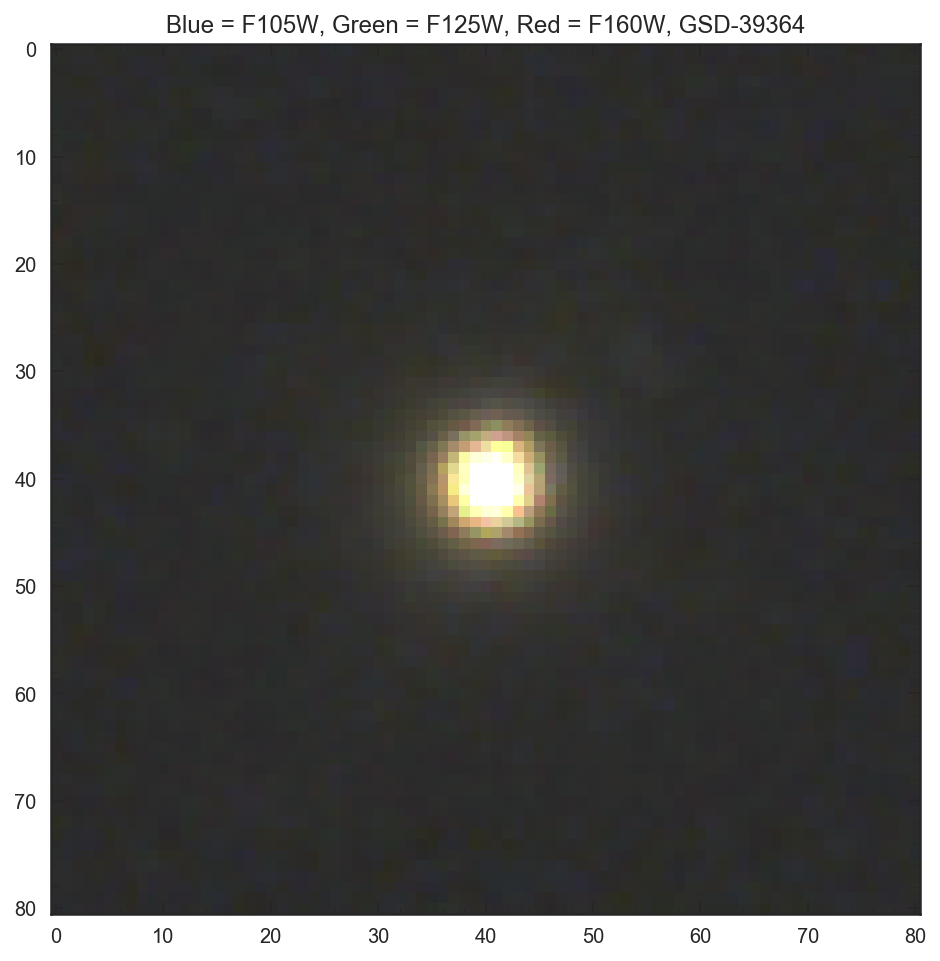

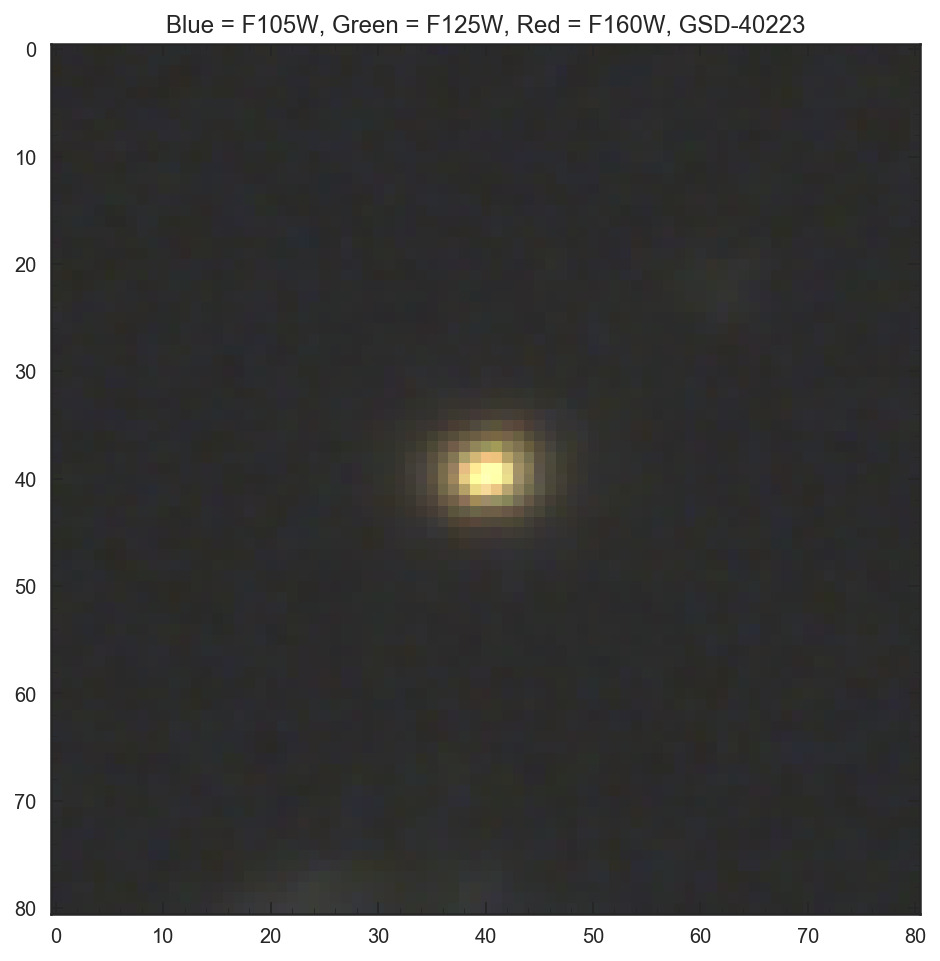

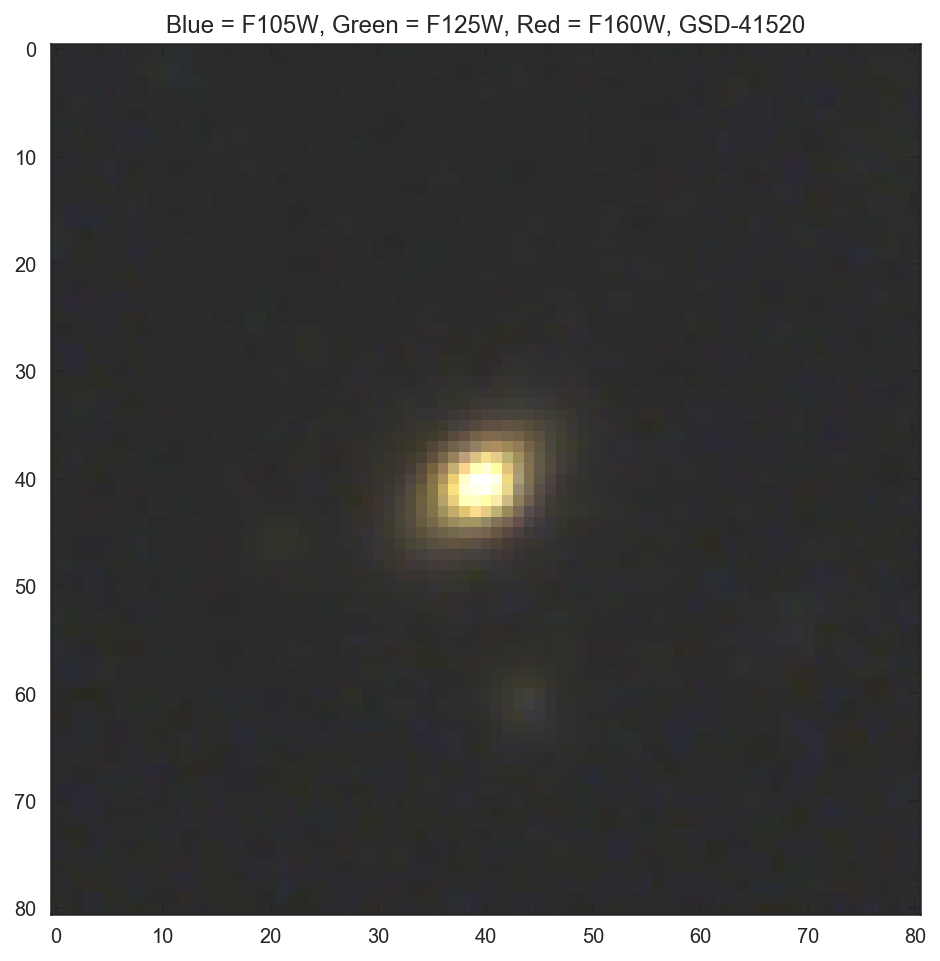

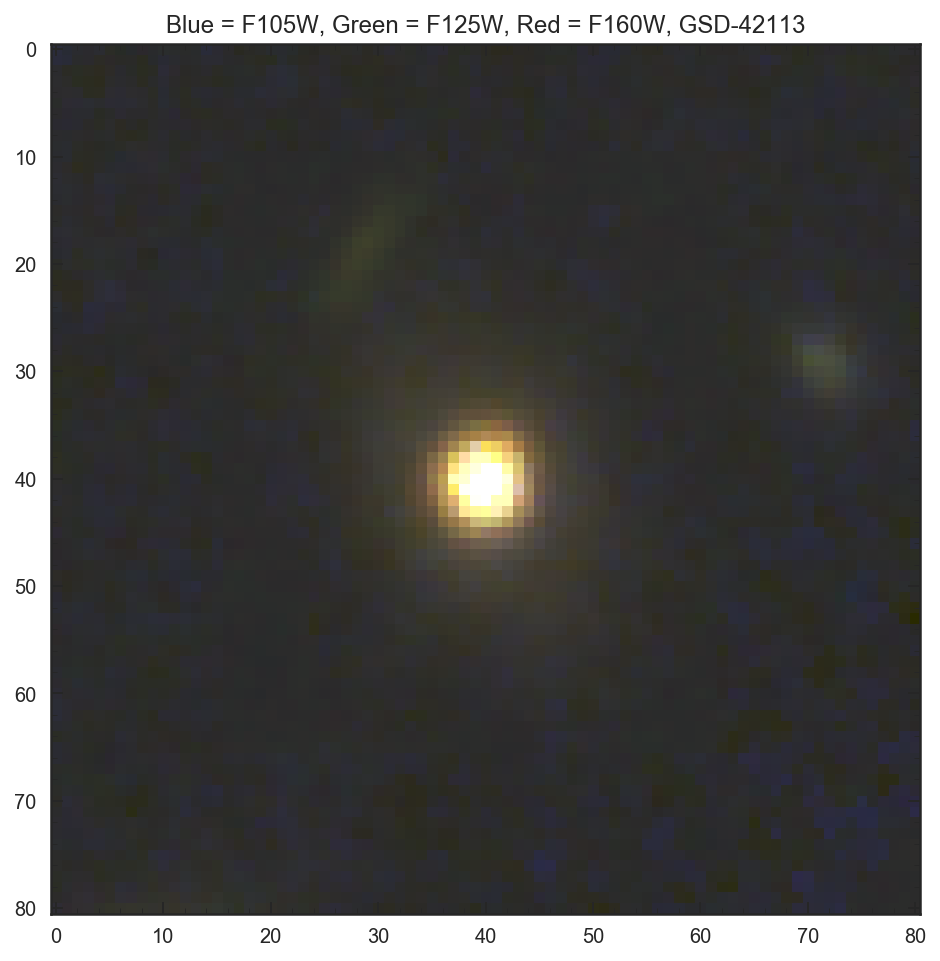

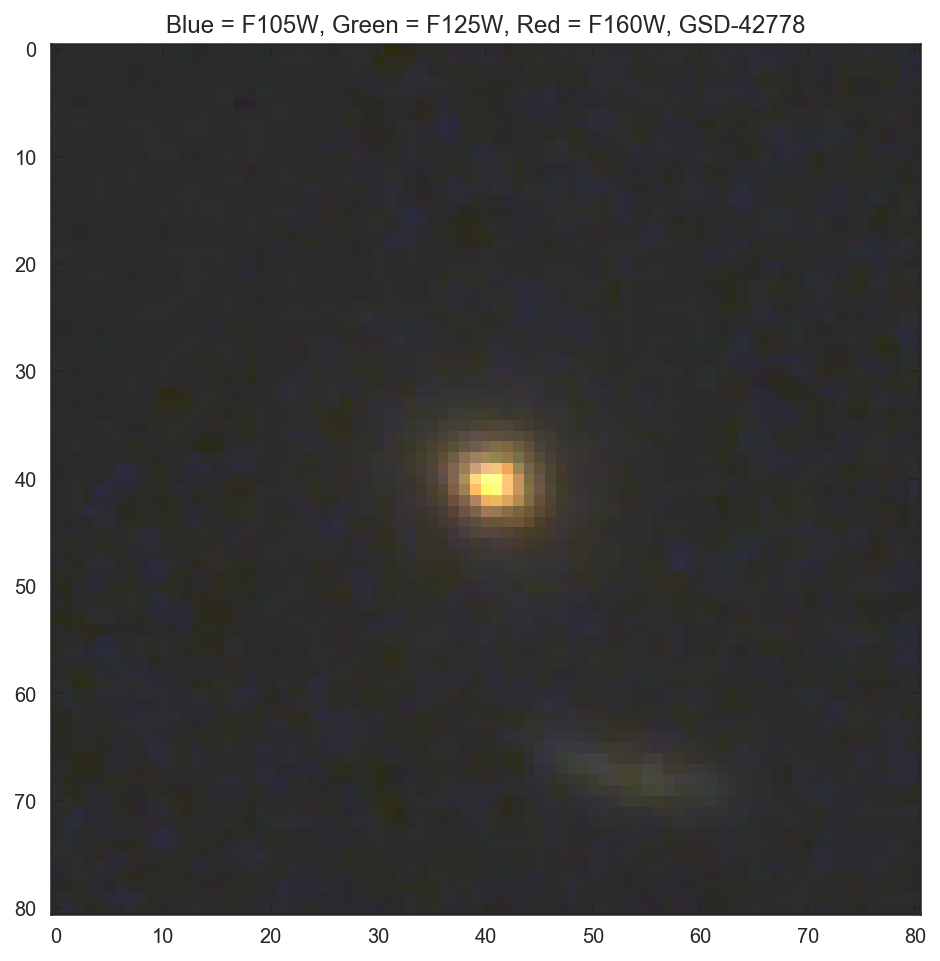

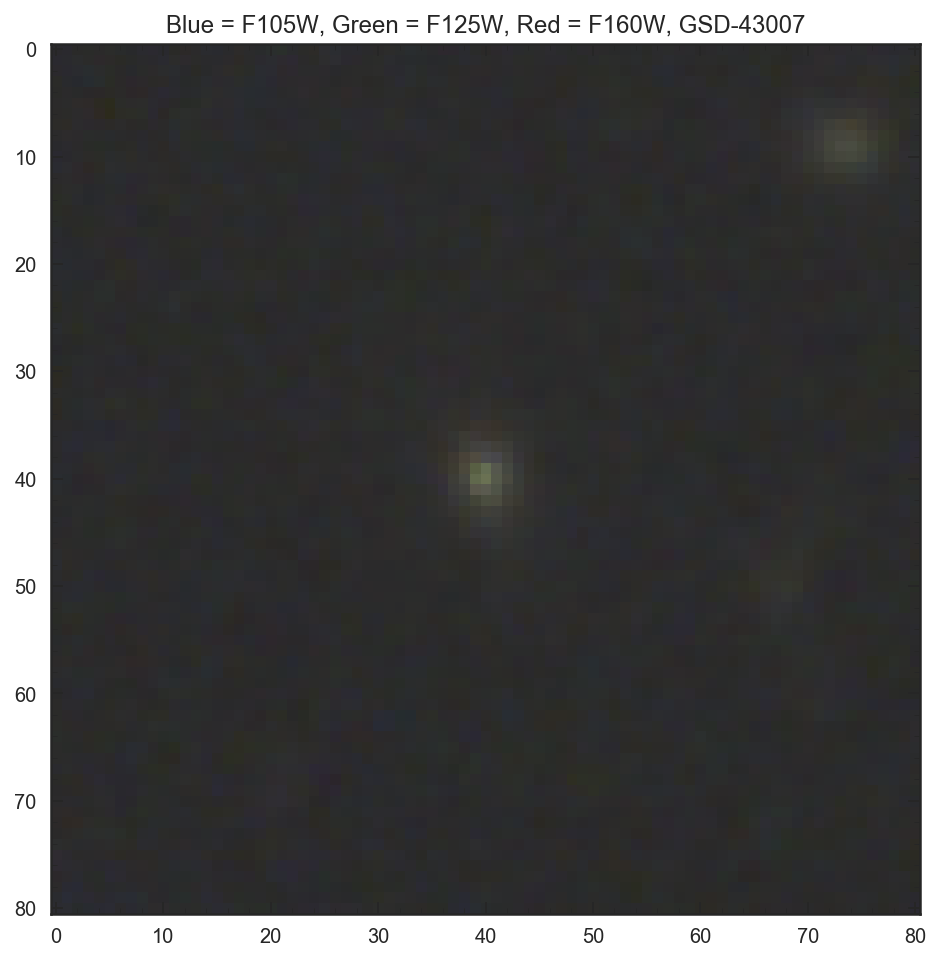

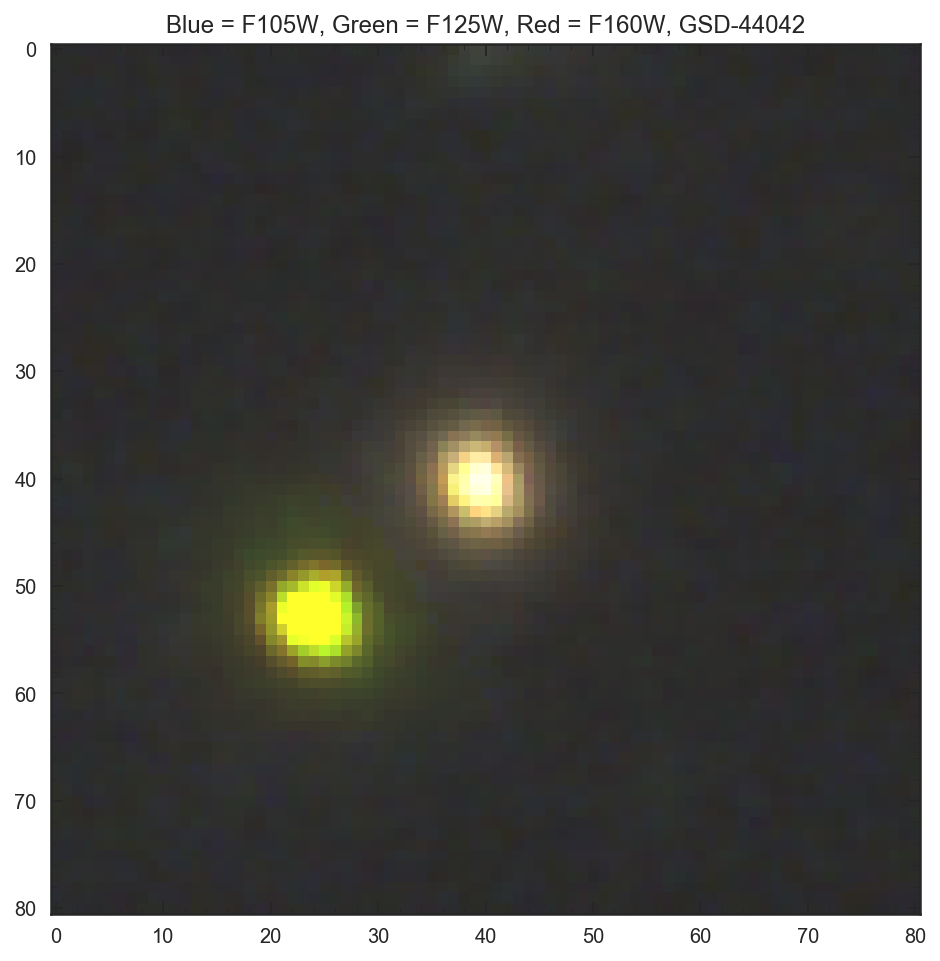

In [44]:
gids = v4S.id[SQ_up].values

for i in gids:
    idx = np.argwhere(seg == i)

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = seg[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img = f105[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img[segimg != i] = 0
    maxloc = np.argwhere(f105img == np.max(f105img))[0]

    ycnt = ylist[maxloc[0]]
    xcnt = xlist[maxloc[1]]

    f105img = f105[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
    f125img = f125[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
    f160img = f160[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]


    img = np.zeros((f125img.shape[0], f125img.shape[1], 3), dtype=float)
    img[:,:,0] = img_scale.asinh(f160img, scale_min=-0.1, scale_max=0.5)
    img[:,:,1] = img_scale.asinh(f125img, scale_min=-0.1, scale_max=0.5)
    img[:,:,2] = img_scale.asinh(f105img, scale_min=-0.1, scale_max=0.5)

    plt.figure(figsize=[8,8])
    plt.imshow(img,aspect='equal')
    plt.title('Blue = F105W, Green = F125W, Red = F160W, GSD-{0}'.format(i))

In [2]:
from spec_extract import Stack
import fsps
def Extract_phot(catalog, galaxy_id, masterlist = '../phot/master_template_list.pkl'):

    galdf = catalog[catalog.id == galaxy_id]
    master_tmp_df = pd.read_pickle(masterlist)

    pre= 'S_'

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in galdf.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if galdf[i].values[0] > -99.0:
                eff_wv.append(master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0])
                phot_fl.append(galdf[i].values[0]*Clam)
                phot_num.append(master_tmp_df.tmp_num[master_tmp_df.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if galdf[i].values[0] > -99.0:
                phot_er.append(galdf[i].values[0]*Clam)
    
    np.save('../Alma_files/GSD_{0}_phot'.format(galaxy_id),[eff_wv,phot_fl,phot_er,phot_num])

    return eff_wv,phot_fl,phot_er,phot_num

def Extract_spec_R2(galaxy_id):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*{0}*1D.fits'.format(galaxy_id))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')

    if len(Bwv) > 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
        np.save('../Alma_files/GSD_{0}_g102'.format(galaxy_id),[SBW, SBF, SBE, SBT, SBL, SBC])
        IDB = [U for U in range(len(SBW)) if 8750 < SBW[U] < 11350]


    if len(Rwv) > 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
        np.save('../Alma_files/GSD_{0}_g141'.format(galaxy_id),[SRW, SRF, SRE, SRT, SRL, SRC])        
        IDR = [U for U in range(len(SRW)) if 11300 < SRW[U] < 16500]
        
        
    if len(Bwv) > 0 and len(Rwv) > 0:
        return SBW[IDB], SBF[IDB] / SBT[IDB], SBE[IDB] / SBT[IDB], SRW[IDR], SRF[IDR] / SRT[IDR], SRE[IDR] / SRT[IDR]
        
    if len(Bwv) > 0 and not len(Rwv) > 0:
        return SBW[IDB], SBF[IDB] / SBT[IDB], SBE[IDB] / SBT[IDB]
        
    if len(Rwv) > 0 and not len(Bwv) > 0:
        return SRW[IDR], SRF[IDR] / SRT[IDR], SRE[IDR] / SRT[IDR]


def Extract_spec_R1(galaxy_id):
    spec_list = glob('/Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/COMBINED/1D/FITS/*S*{0}*1D.fits'.format(galaxy_id))

    Bwv, Bfl, Ber, Bft = [[],[],[],[]]


    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        Bwv.append(np.array(dat[1].data['wave']))
        Bfl.append(np.array(dat[1].data['flux']) - np.array(dat[1].data['contam']))
        Ber.append(np.array(dat[1].data['error']))
        Bft.append(np.array(dat[1].data['sensitivity']))


    SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, np.ones_like(Bwv), np.ones_like(Bwv))
    np.save('../Alma_files/GSD_{0}_g102'.format(galaxy_id),[SBW, SBF* 1E-17, SBE* 1E-17, SBT, SBL, SBC])

    IDB = [U for U in range(len(SBW)) if 8750 < SBW[U] < 11350]

    return SBW[IDB], SBF[IDB] / SBT[IDB] * 1E-17, SBE[IDB] / SBT[IDB] * 1E-17

In [15]:
gals = [26272, 29257, 38843, 39012, 39364, 40223, 41520, 42113, 42778,43007, 44042]
for i in gals:
    Extract_spec_R2(i)


/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_fiel

no g102
no g102
no g102
no g102
no g102


In [17]:
dat = fits.open(spec_list[0])

In [18]:
wv = dat[1].data['wave']
fl = dat[1].data['flux']
er = dat[1].data['error']
cntm = dat[1].data['contam']
sens = dat[1].data['sensitivity']

<ErrorbarContainer object of 3 artists>

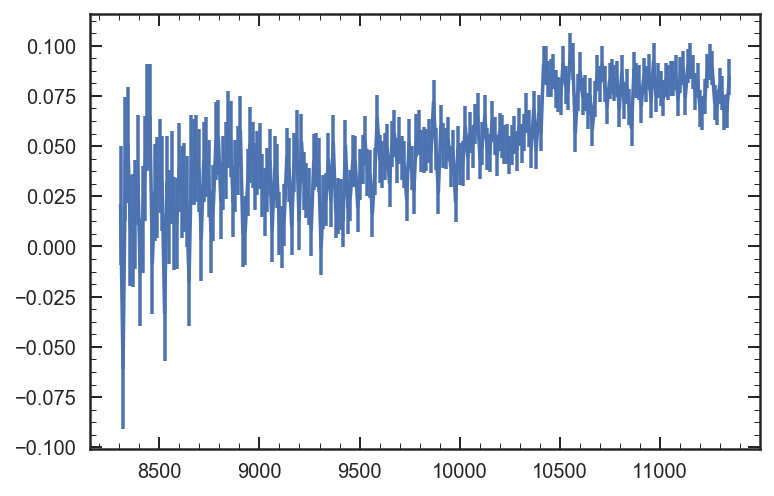

In [34]:
IDX = [U for U in range(len(wv)) if 8300 < wv[U] < 11350]

plt.errorbar(wv[IDX],(fl[IDX] - cntm[IDX]) / sens[IDX],er[IDX]/ sens[IDX])

# Build plotting code

In [21]:

def PLOT(galaxy_id, lims = None, savefig = True):
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 4, tau=0.1, dust_type = 1)

    def Calibrate_grism(wvs, flxs, errs, Gmfl, p1):
        linecal = []
        for i in range(len(wvs)):
            lines = (p1[i] * (wvs[i] -(wvs[i][-1] + wvs[i][0])/2 ) + 1E3)
            scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
            linecal.append(scale * lines)

        return linecal
    
    
    def Full_forward_model(spec, wave, flux, specz, wvs, flxs, errs, beams, trans ):
        Gmfl = []

        for i in range(len(wvs)):
            Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

        Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

        return np.array(Gmfl), Pmfl
    
    m, a, bsc, rsc, bp1, rp1, lm, z, d, t, logl = np.load('../data/bestfits/ALMA_{0}_bfit.npy'.format(galaxy_id))

    Gs = Gen_ALMA_spec(galaxy_id, z, g102_lims=[8750,11300], g141_lims=[lims[0],lims[1]], mdl_err=False)
    wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux, wave*(1+z) , z, 0, sp.stellar_mass)*10**lm, z, wvs, flxs, errs, beams, trans)

    bscale = Calibrate_grism(wvs, flxs, errs, Gmfl, [bp1,rp1])

    gs = GridSpec(2,3, hspace=0.3, wspace = 0.3)   
   
    plt.figure(figsize=[14,10])
    plt.subplot(gs[0,:])
    plt.errorbar(np.log10(Gs.Bwv_rf), flxs[0] / bscale[0],errs[0] / bscale[0],
                    linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
    plt.errorbar(np.log10(Gs.Rwv_rf), flxs[1] / bscale[1],errs[1] / bscale[1],
                    linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                     linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
    plt.plot(np.log10(Gs.Bwv_rf),Gmfl[0], 'k', zorder=5)
    plt.plot(np.log10(Gs.Rwv_rf), Gmfl[1], 'k', zorder=5)
    plt.plot(np.log10(Gs.Pwv_rf), Pmfl, 'k*' , zorder=5)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.ylim(0,max(Gs.Pflx) * 1.5)            
    plt.title(galaxy_id, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############img plot################
    idx = np.argwhere(seg == galaxy_id)

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = seg[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img = f105[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img[segimg != galaxy_id] = 0
    maxloc = np.argwhere(f105img == np.max(f105img))[0]

    ycnt = ylist[maxloc[0]]
    xcnt = xlist[maxloc[1]]

    f105img = f105[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
    f125img = f125[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
    f160img = f160[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]

    img = np.zeros((f125img.shape[0], f125img.shape[1], 3), dtype=float)
    img[:,:,0] = img_scale.asinh(f160img, scale_min=-0.1, scale_max=0.5)
    img[:,:,1] = img_scale.asinh(f125img, scale_min=-0.1, scale_max=0.5)
    img[:,:,2] = img_scale.asinh(f105img, scale_min=-0.1, scale_max=0.5)

    plt.subplot(gs[1,0])
    plt.imshow(img,aspect='equal')
    plt.title('Blue = F105W, Green = F125W, Red = F160W', fontsize = 10)
    
    ###############plot location################
    plt.subplot(gs[1,1])
    for i in range(len(allpos)):
        plt.plot(allpos[i][0],allpos[i][1], 'k',alpha = 0.05,zorder=1)

    plt.scatter(v4S.ra[SQ_up],v4S.dec[SQ_up],marker='*', s=200, color = 'b')        
    plt.scatter(v4S.ra[galaxy_id - 1],v4S.dec[galaxy_id - 1],marker='*', s=200, color = 'r')
    plt.xlabel('ra', fontsize=15)
    plt.ylabel('dec', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    ###############plot P(z)################
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(galaxy_id))
    
    plt.subplot(gs[1,2])
    plt.plot(z,pz)
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)

    if savefig:
        plt.savefig('../plots/ALMA/all_data_{0}_up.png'.format(galaxy_id),bbox_inches = 'tight')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


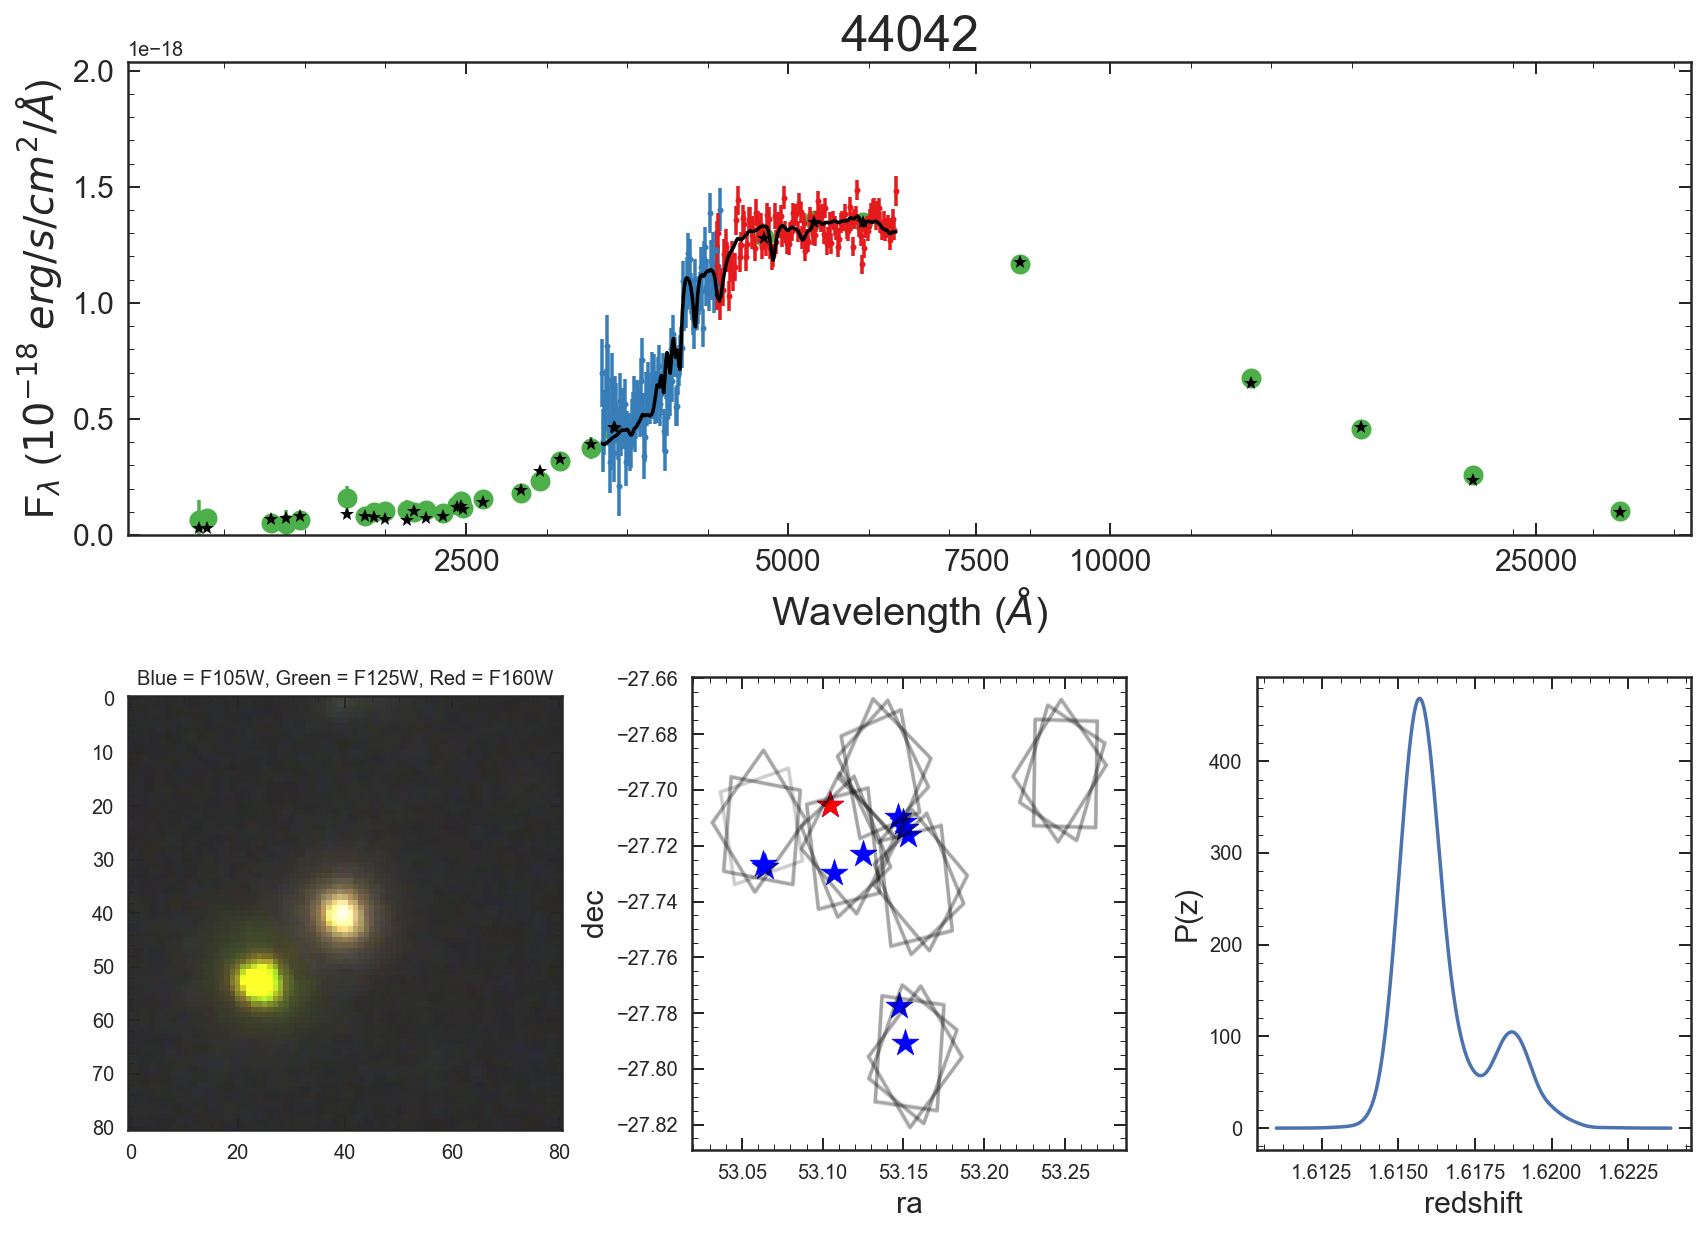

In [20]:
PLOT(44042, lims=[11200,16500],savefig=False)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


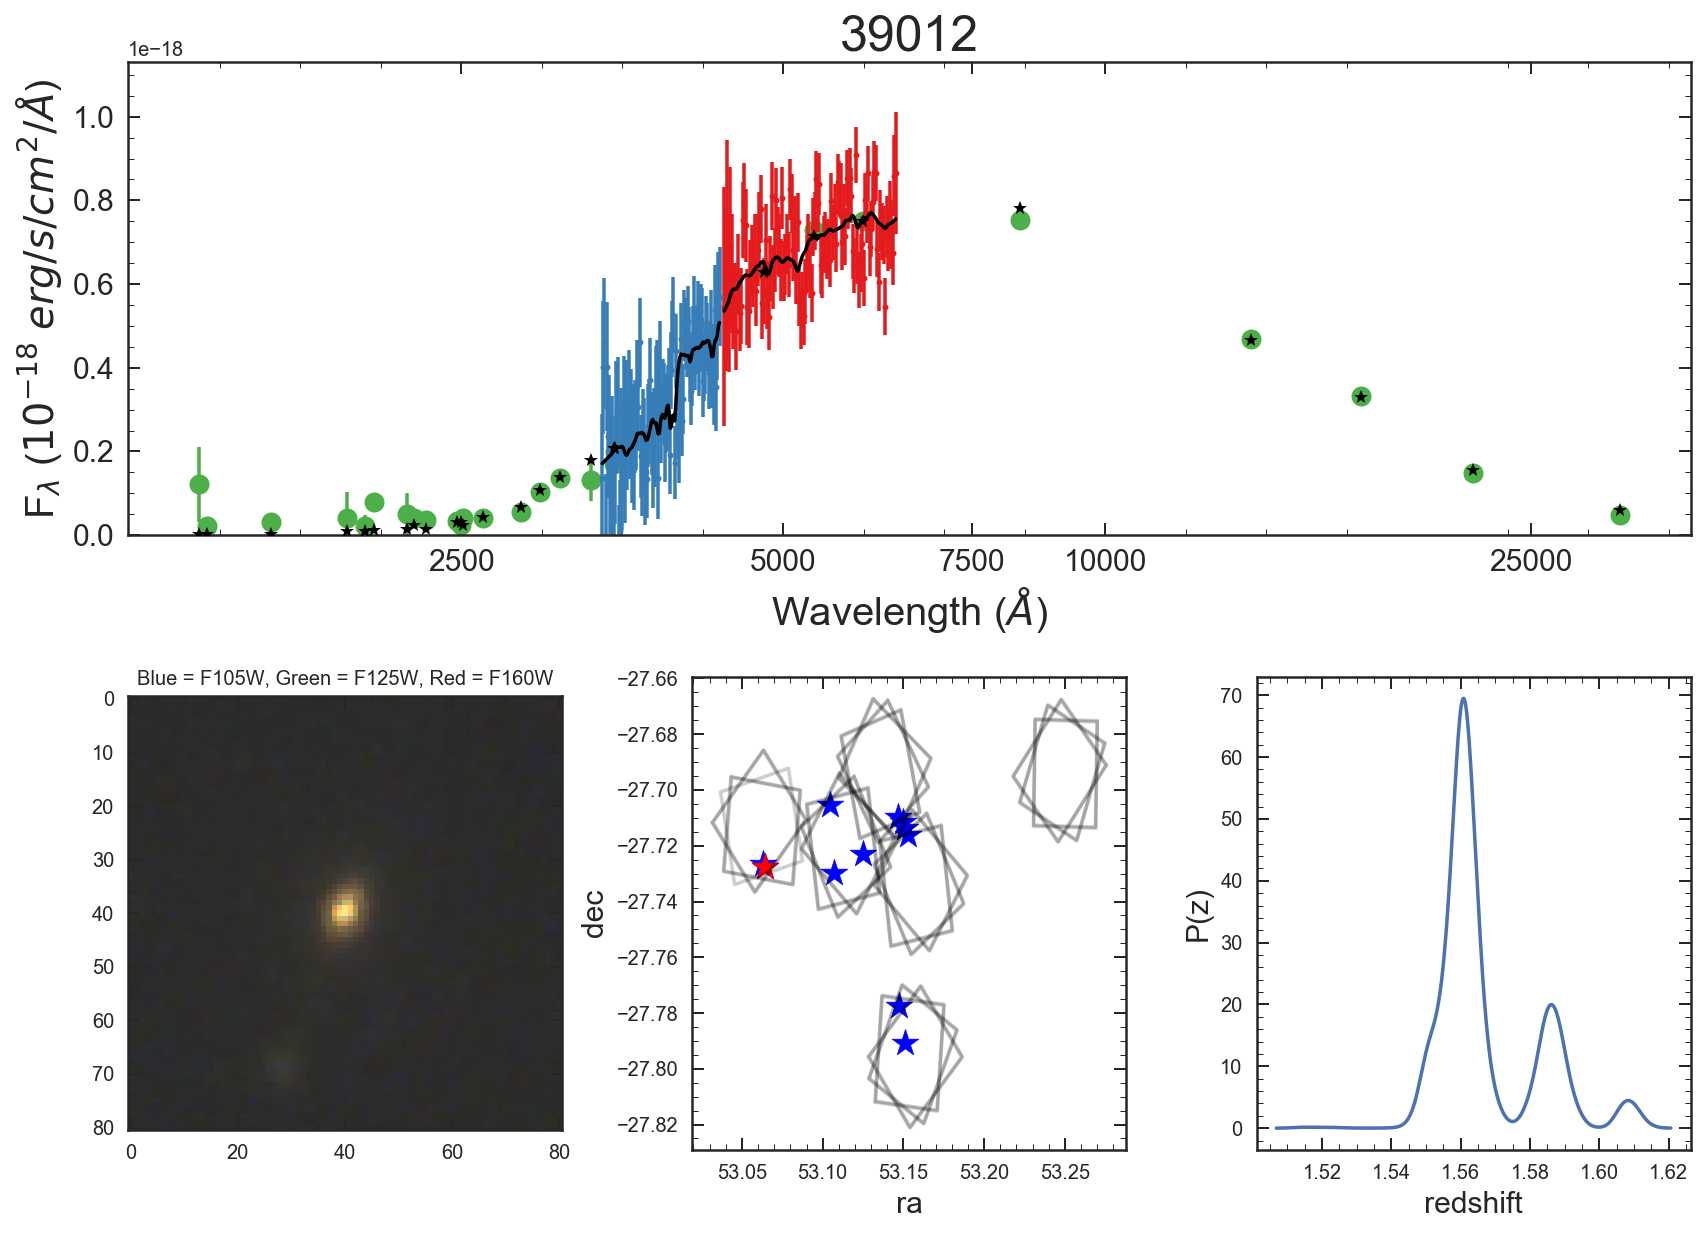

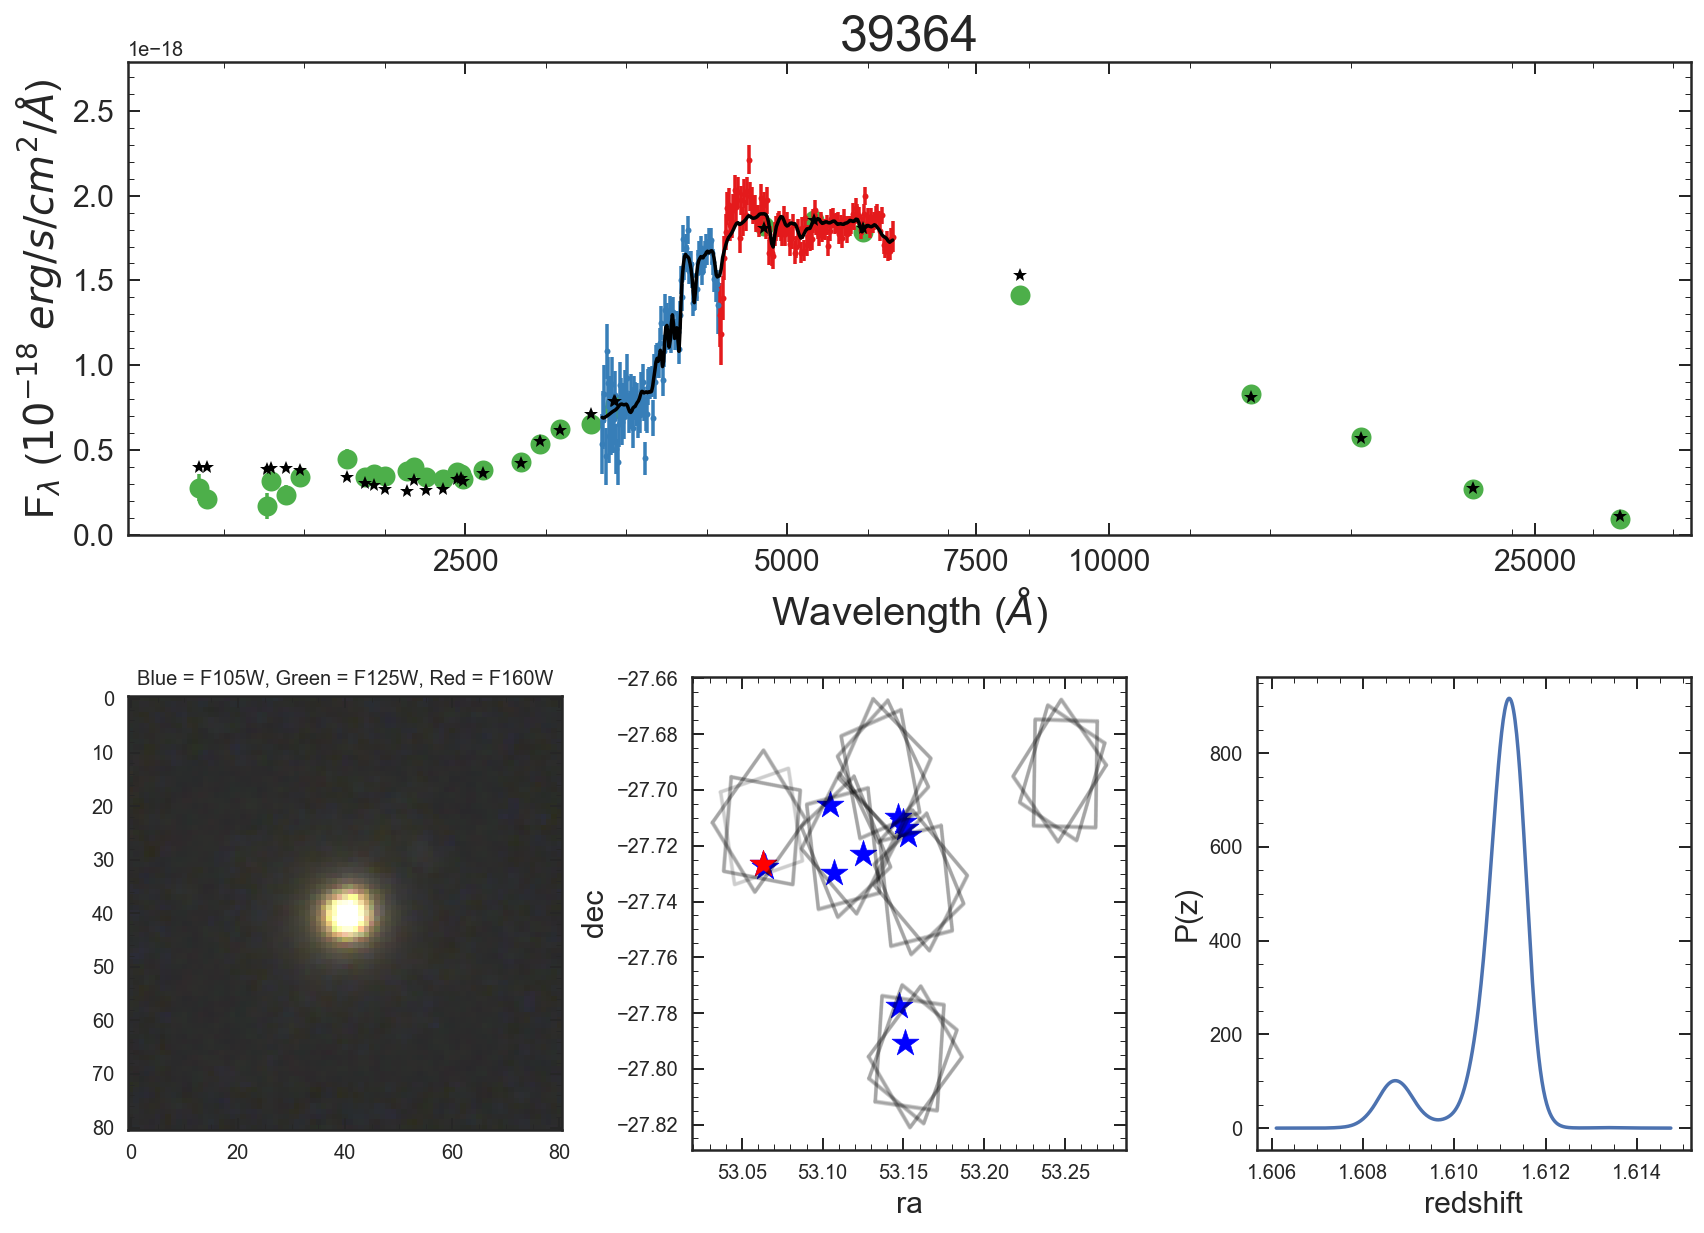

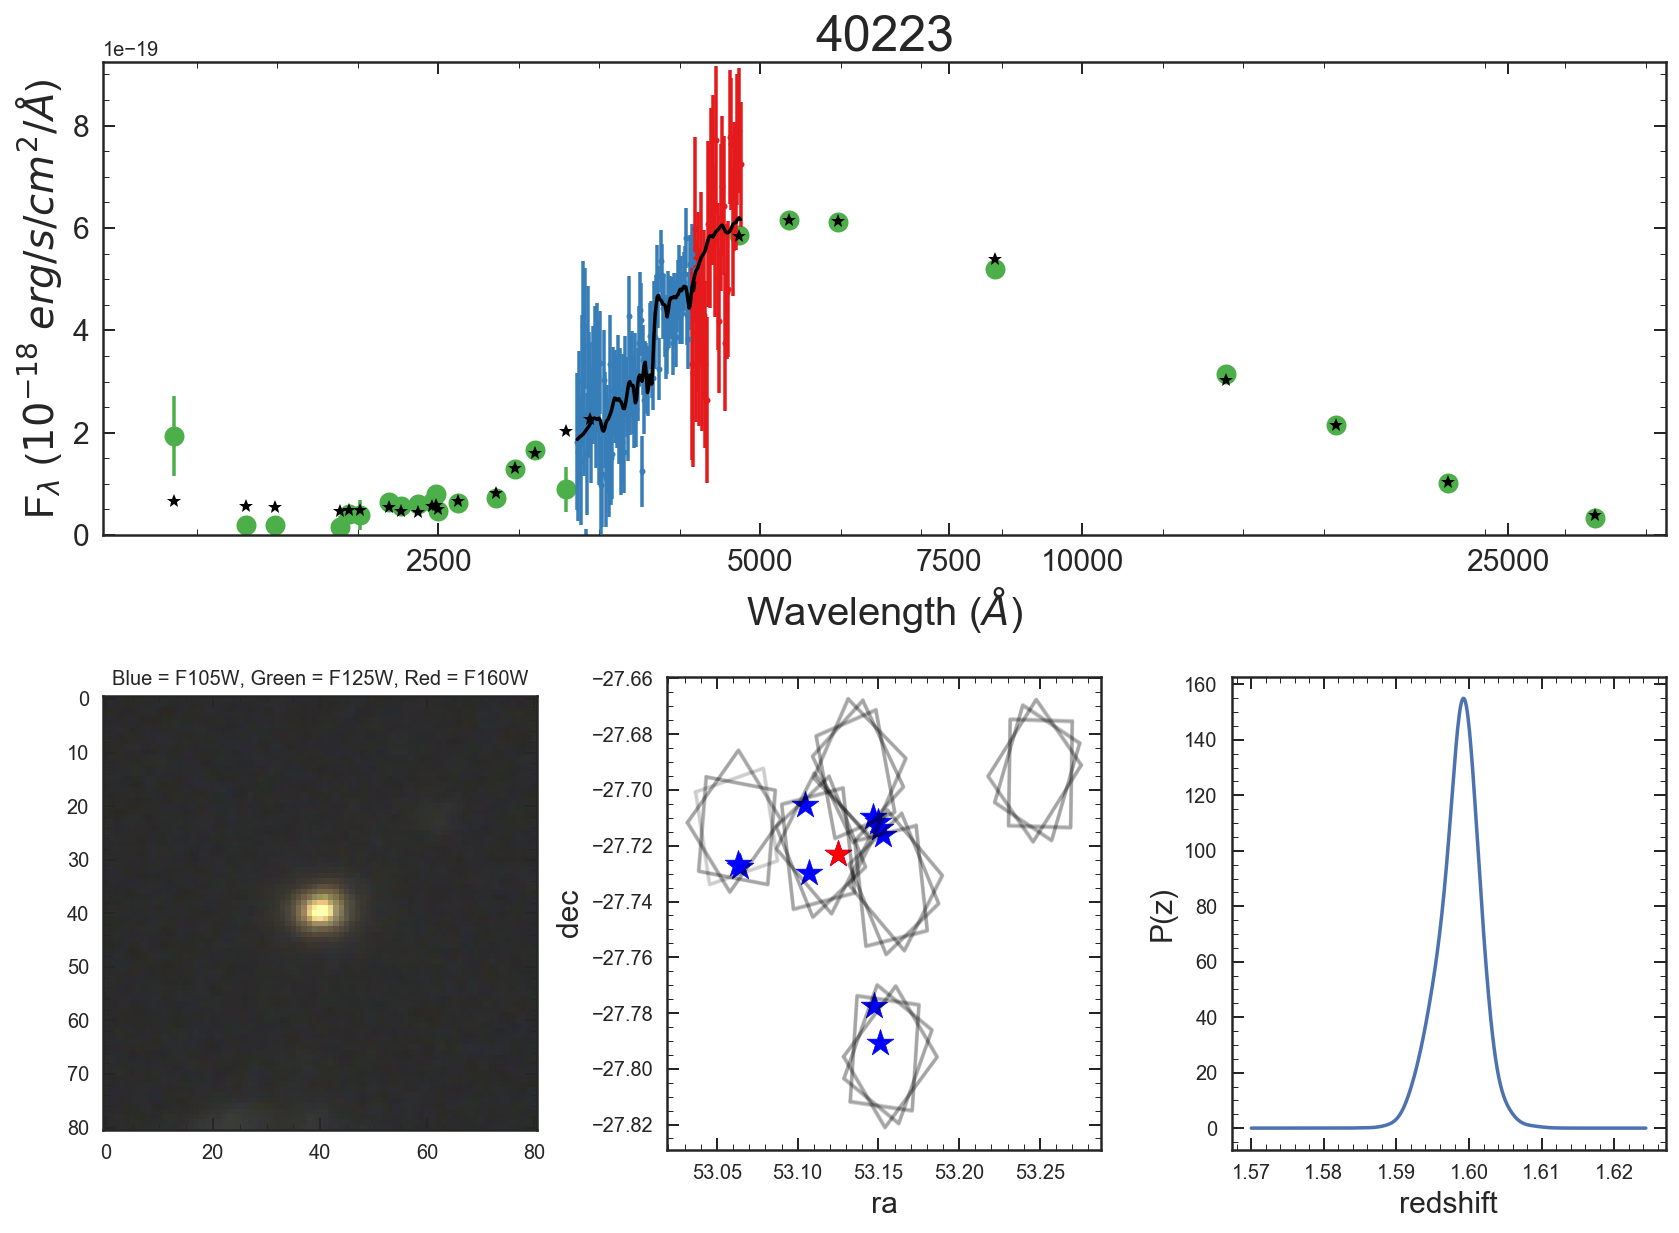

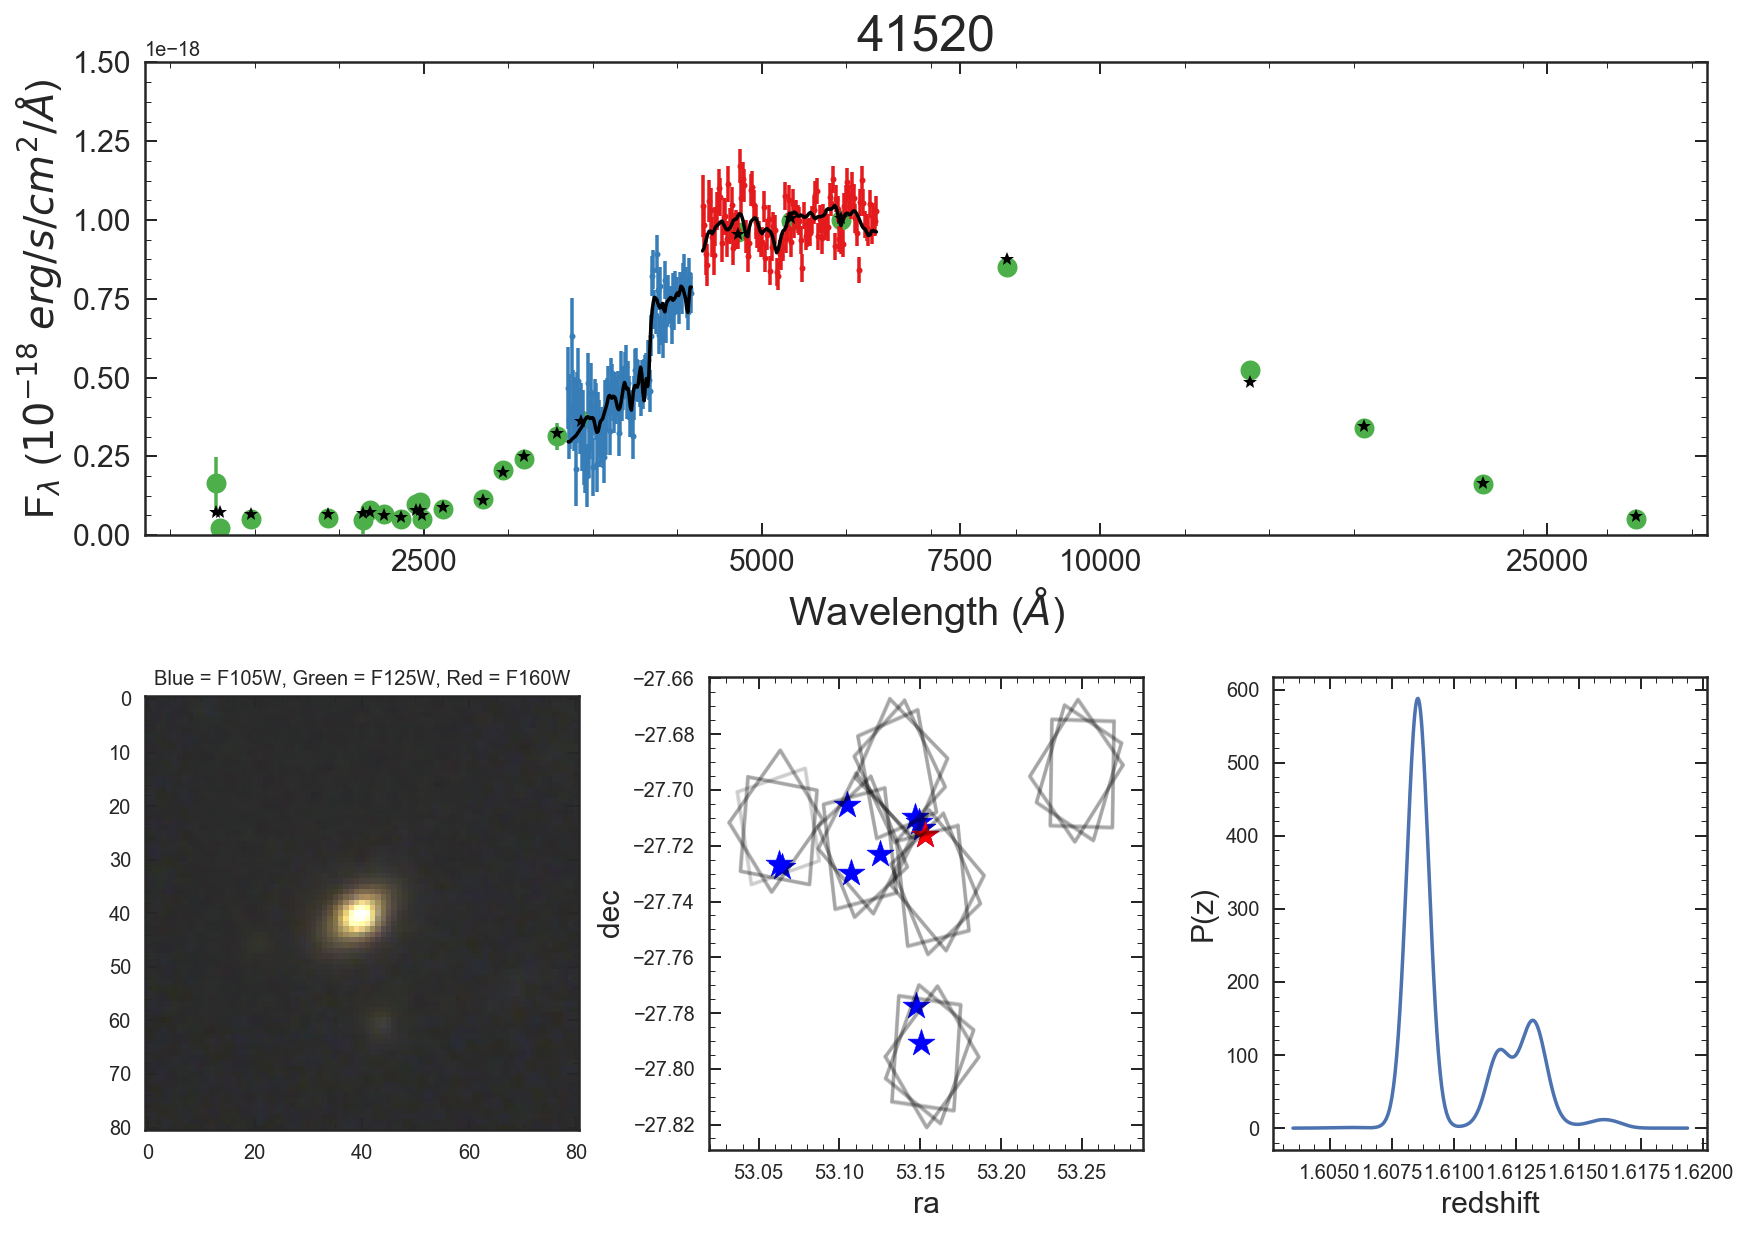

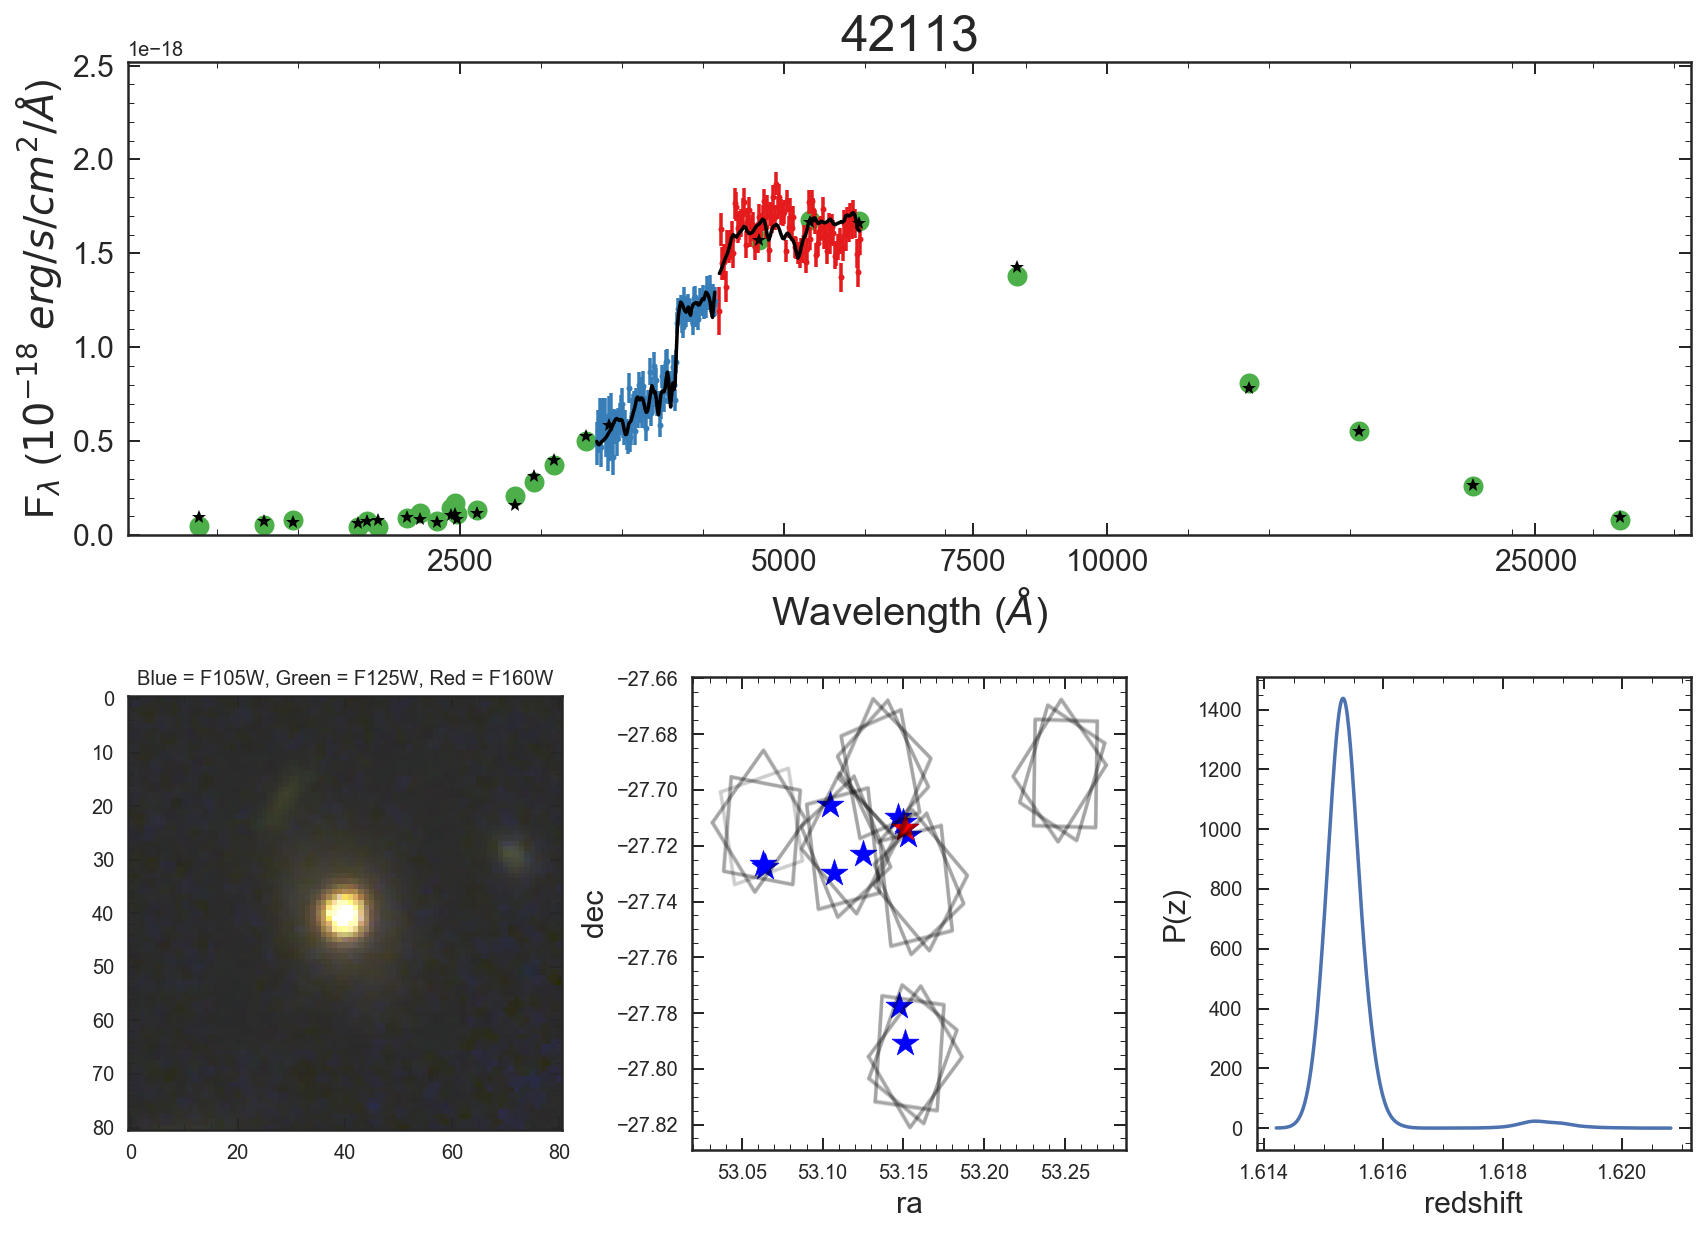

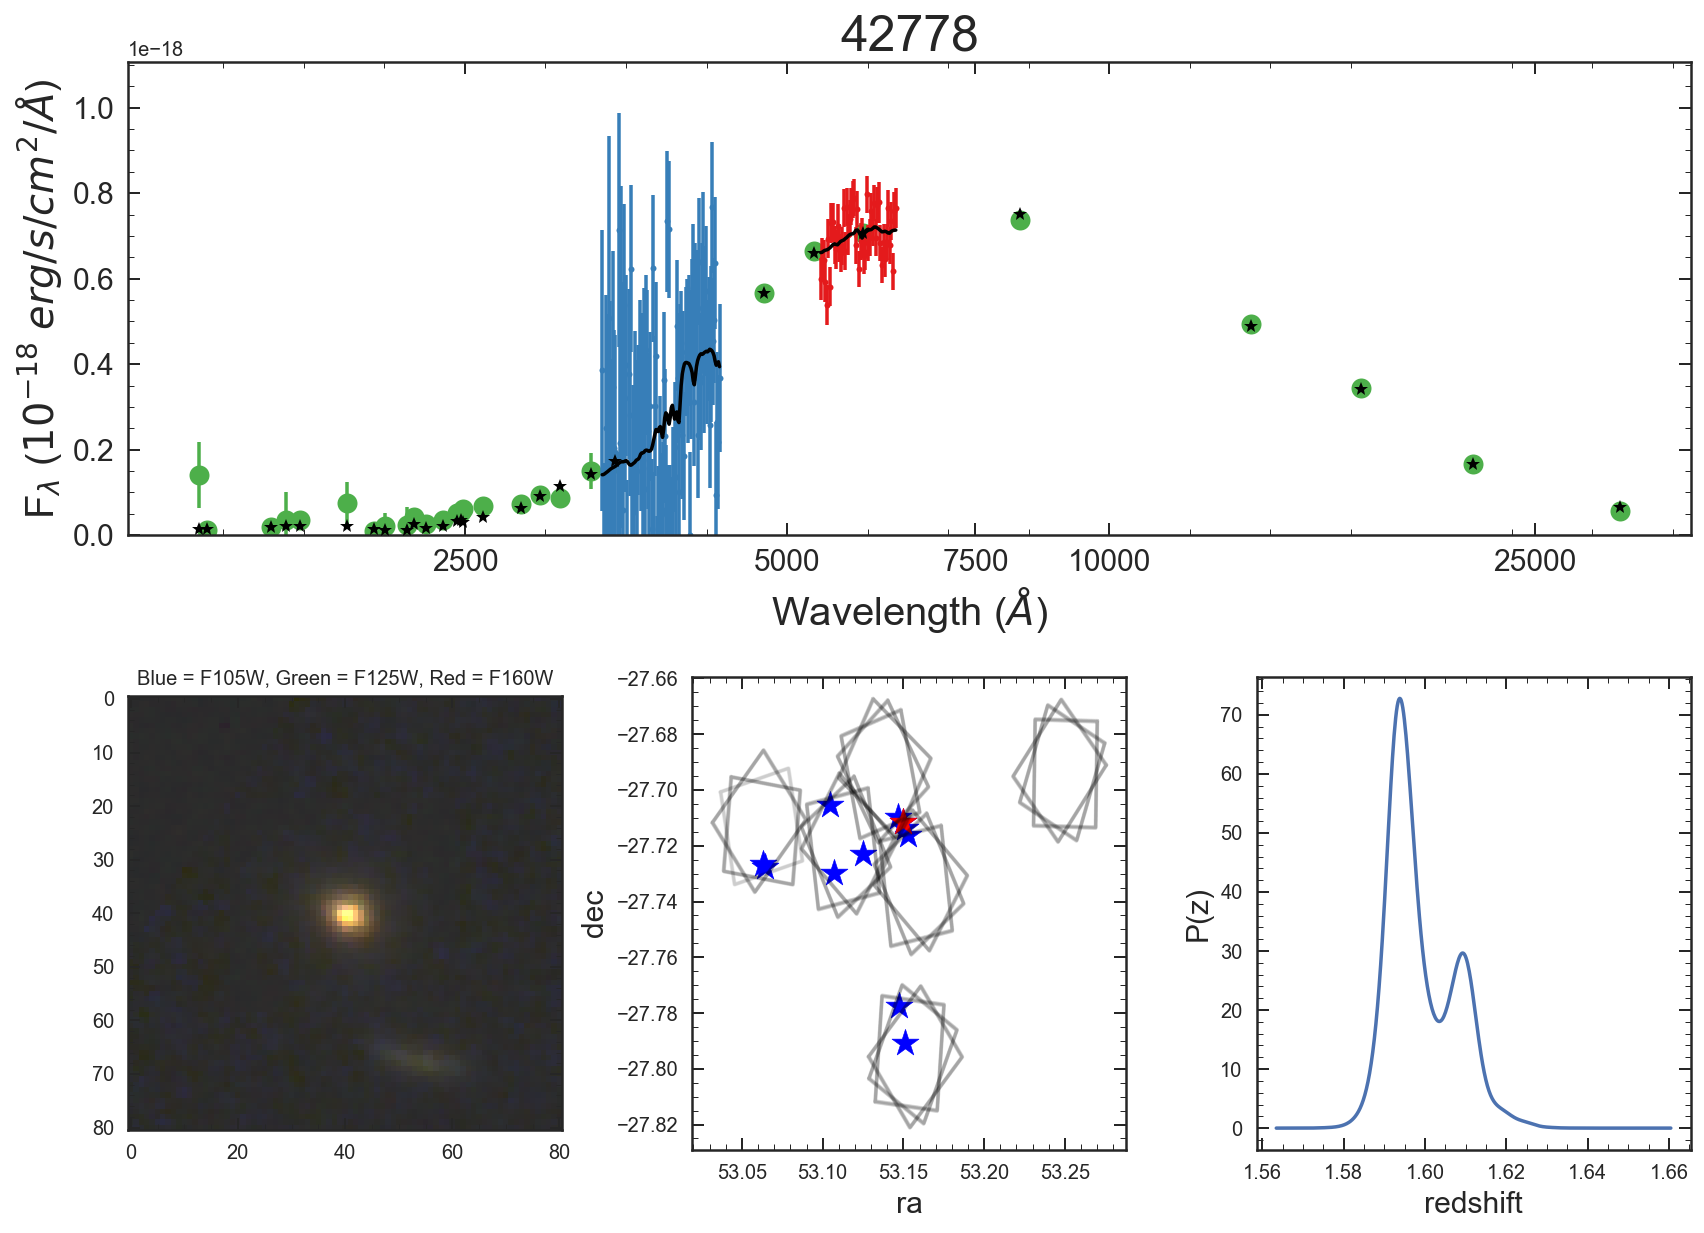

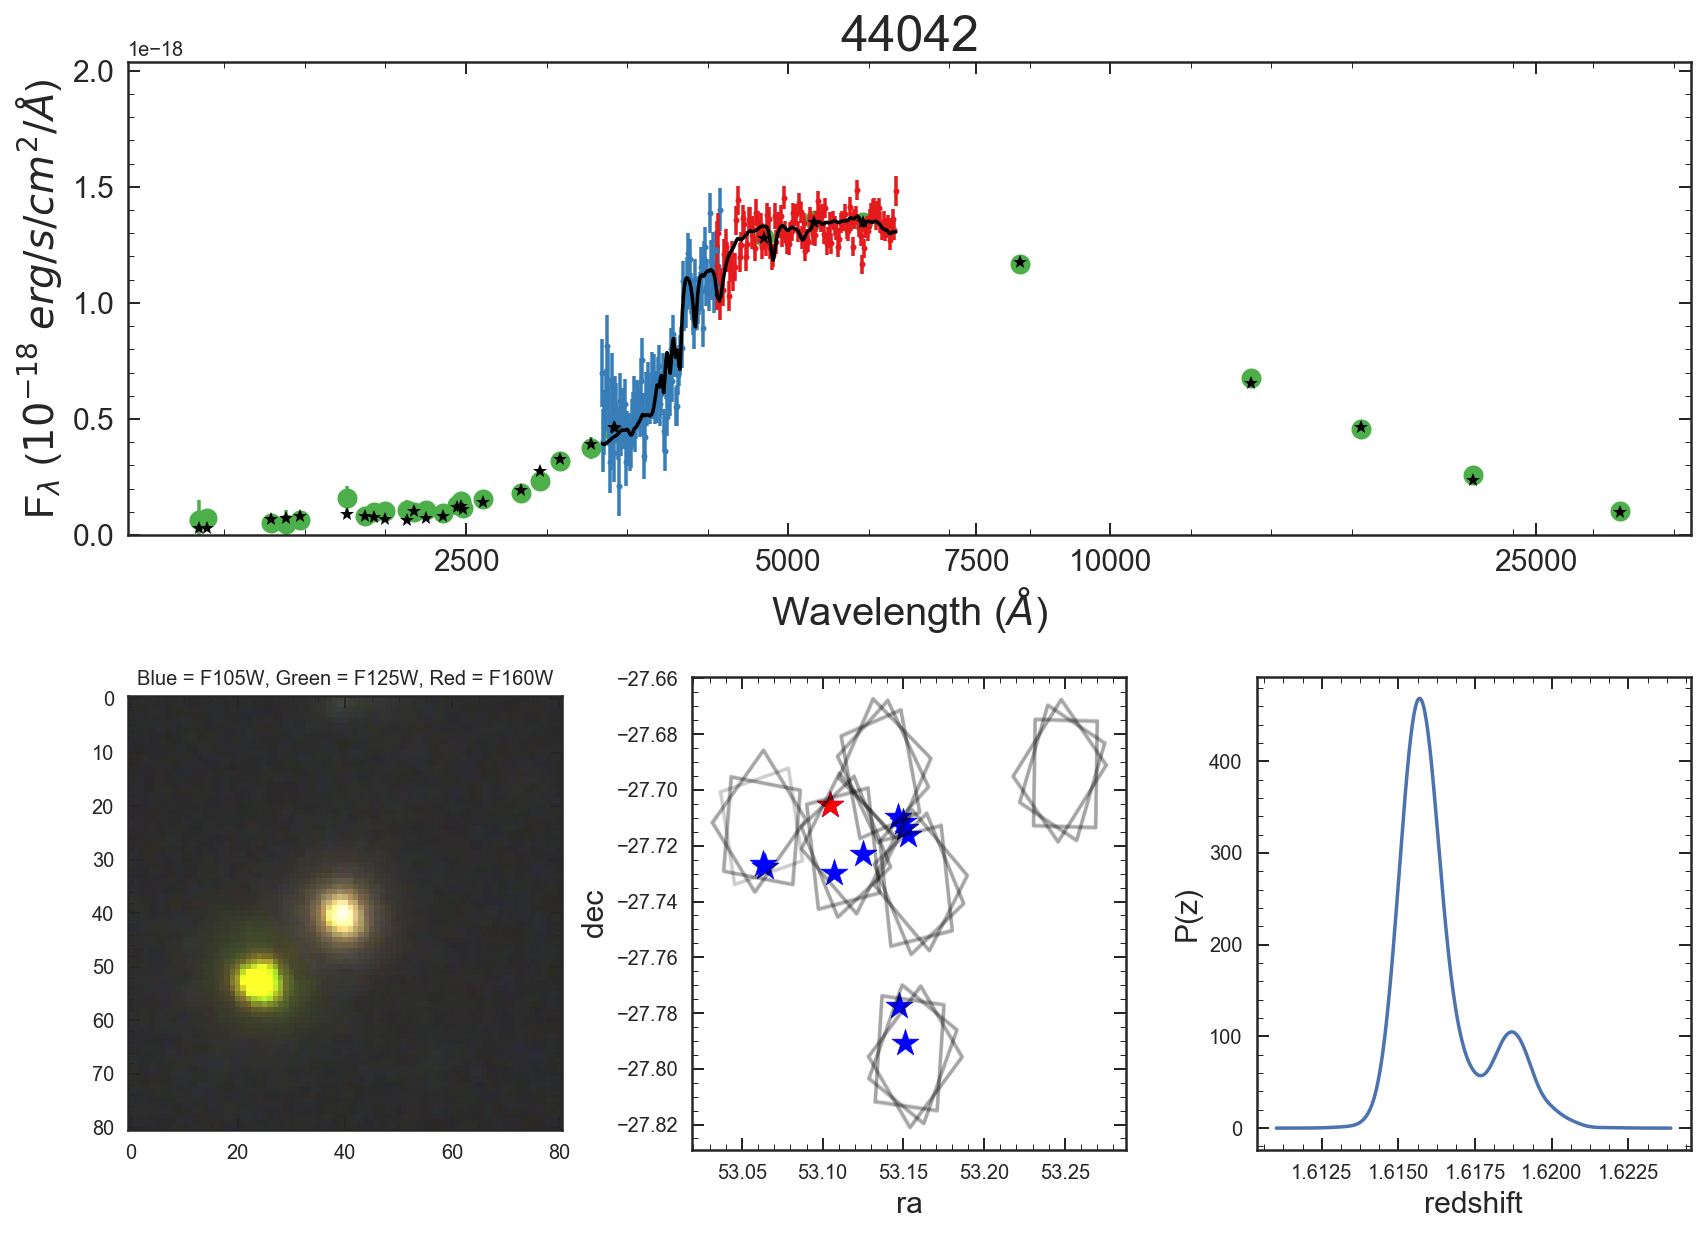

In [22]:
# gals = [26272, 29257, 38843, 39012, 39364, 40223, 41520, 42113, 42778,43007, 44042]

# LIMSR = [None, None, None, None, None, [11200,12500], None, [11200,15400], [14000,16500], None, None]

gals = [39012, 39364, 40223, 41520, 42113, 42778, 44042]

LIMSR = [ None, None, [11200,12500], None, [11200,15400], [14000,16500], None]

for i in range(len(gals)):
    if LIMSR[i] == None:
        lim1 = 11200
        lim2 = 16500
    else:
        lim1 = LIMSR[i][0]
        lim2 = LIMSR[i][1]

    PLOT(gals[i], [lim1,lim2], savefig = True)    
#     PLOT(gals[i], [11200,16500], savefig = False)

In [51]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 4, tau=0.1, dust_type = 1)

def Calibrate_grism(wvs, flxs, errs, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = (p1[i] * (wvs[i] -(wvs[i][-1] + wvs[i][0])/2 ) + 1E3)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)

    return linecal


def Full_forward_model(spec, wave, flux, specz, wvs, flxs, errs, beams, trans ):
    Gmfl = []

    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

In [ ]:
np.

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


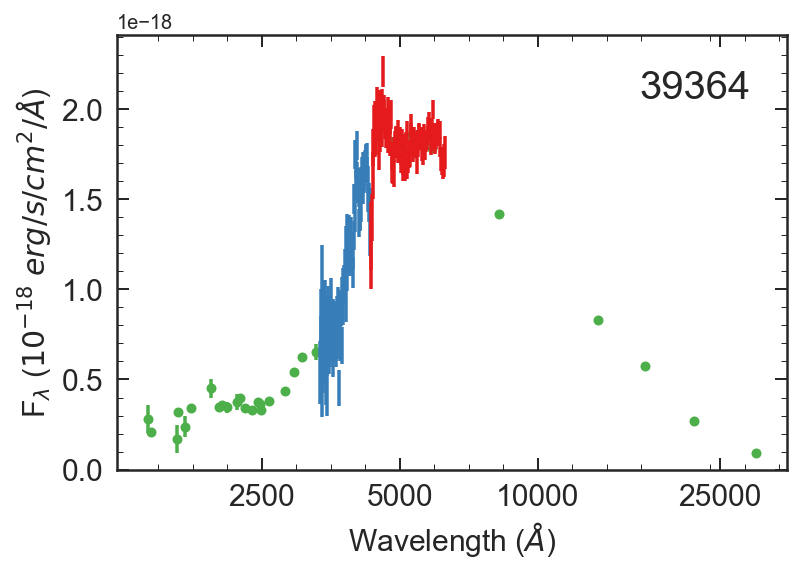

In [26]:
i=1
gs1 = i - 4 * (i//4)
gs2 = i//4    

if LIMSR[i] == None:
    lim1 = 11200
    lim2 = 16500
else:
    lim1 = LIMSR[i][0]
    lim2 = LIMSR[i][1]

lims = [lim1,lim2]
galaxy_id = gals[i]

m, a, bsc, rsc, bp1, rp1, lm, z, d, t, logl = np.load('../data/bestfits/ALMA_{0}_bfit.npy'.format(galaxy_id))

Gs = Gen_ALMA_spec(galaxy_id, z, g102_lims=[8750,11300], g141_lims=[lims[0],lims[1]], mdl_err=False)
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 4, tau=0.1, dust_type = 1)

wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)
sp.params['tau'] = t

wave, flux = sp.get_spectrum(tage = a, peraa = True)

Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux, wave*(1+z) , z, 0, 
                                                      sp.stellar_mass)*10**lm, z, wvs, flxs, errs, beams, trans)

bscale = Calibrate_grism(wvs, flxs, errs, Gmfl, [bp1,rp1])

plt.errorbar(np.log10(Gs.Bwv_rf), flxs[0] / bscale[0],errs[0] / bscale[0],
                linestyle='None', marker='o', markersize=0, color='#377eb8',zorder = 2)
plt.errorbar(np.log10(Gs.Rwv_rf), flxs[1] / bscale[1],errs[1] / bscale[1],
                linestyle='None', marker='o', markersize=0, color='#e41a1c',zorder = 2)
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                linestyle='None', marker='o', markersize=5, color='#4daf4a',zorder = 1)
plt.plot([],[], 'o', color='#4daf4a',  label = galaxy_id)
plt.xticks(np.log10([2500,5000, 10000, 25000]),[2500,5000, 10000,25000])
plt.ylim(0,max(Gs.Pflx) * 1.3)            
plt.legend(fontsize=20,markerscale = 0 )
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/mini

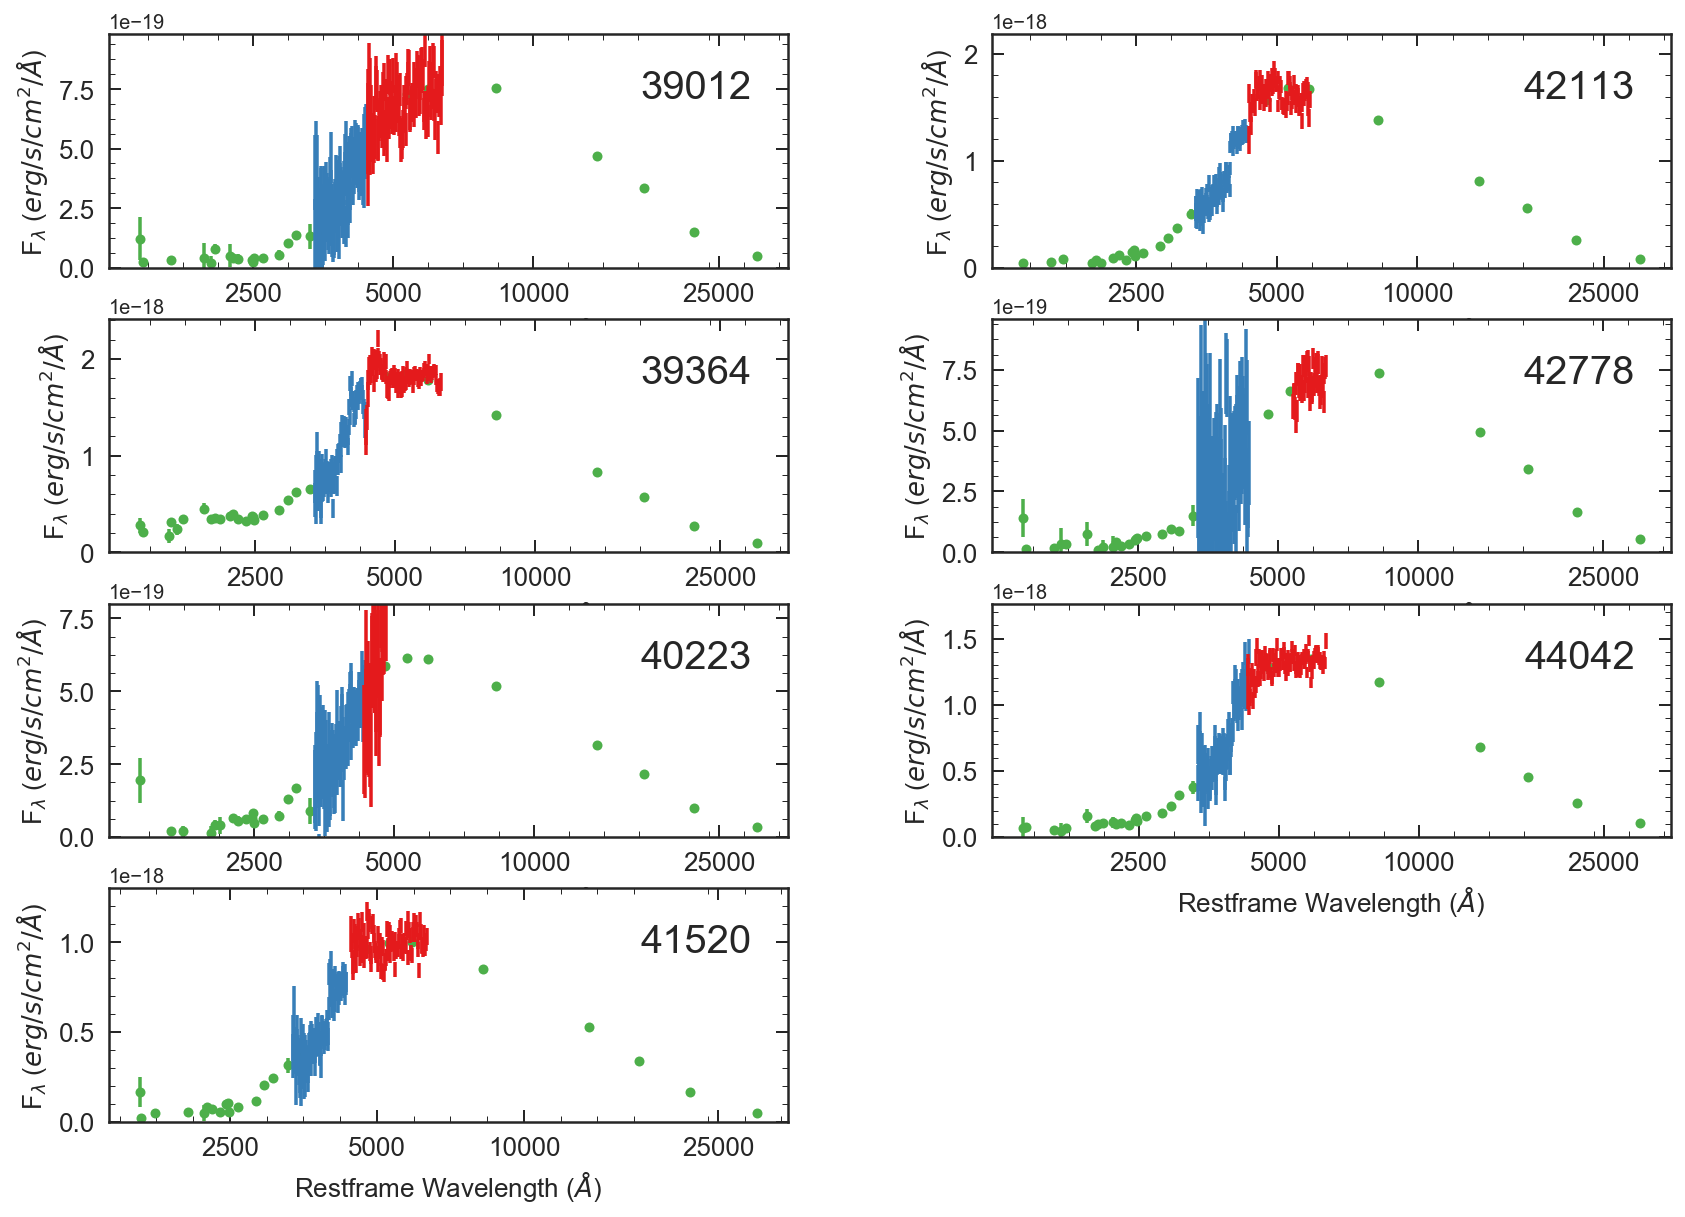

In [31]:
gals = [39012, 39364, 40223, 41520, 42113, 42778, 44042]

LIMSR = [ None, None, [11200,12500], None, [11200,15400], [14000,16500], None]
    
gs = GridSpec(4,2, hspace=0.22, wspace = 0.3)   

plt.figure(figsize=[14,10])

for i in range(len(gals)):
    gs1 = i - 4 * (i//4)
    gs2 = i//4    
    
    if LIMSR[i] == None:
        lim1 = 11200
        lim2 = 16500
    else:
        lim1 = LIMSR[i][0]
        lim2 = LIMSR[i][1]
      
    lims = [lim1,lim2]
    galaxy_id = gals[i]
    
    m, a, bsc, rsc, bp1, rp1, lm, z, d, t, logl = np.load('../data/bestfits/ALMA_{0}_bfit.npy'.format(galaxy_id))

    Gs = Gen_ALMA_spec(galaxy_id, z, g102_lims=[8750,11300], g141_lims=[lims[0],lims[1]], mdl_err=False)
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 4, tau=0.1, dust_type = 1)

    wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux, wave*(1+z) , z, 0, 
                                                          sp.stellar_mass)*10**lm, z, wvs, flxs, errs, beams, trans)

    bscale = Calibrate_grism(wvs, flxs, errs, Gmfl, [bp1,rp1])

    plt.subplot(gs[gs1,gs2])
    
    plt.errorbar(np.log10(Gs.Bwv_rf), flxs[0] / bscale[0],errs[0] / bscale[0],
                    linestyle='None', marker='o', markersize=0, color='#377eb8',zorder = 2)
    plt.errorbar(np.log10(Gs.Rwv_rf), flxs[1] / bscale[1],errs[1] / bscale[1],
                    linestyle='None', marker='o', markersize=0, color='#e41a1c',zorder = 2)
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                    linestyle='None', marker='o', markersize=5, color='#4daf4a',zorder = 1)
    plt.plot([],[], 'o', color='#4daf4a',  label = galaxy_id)
    plt.xticks(np.log10([2500,5000, 10000, 25000]),[2500,5000, 10000,25000])
    plt.ylim(0,max(Gs.Pflx) * 1.3)            
    plt.legend(fontsize=20,markerscale = 0 )
    plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=13)
    plt.ylabel('F$_\lambda$ ($erg/s/cm^{2}/\AA $)', fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=13)

plt.savefig('../plots/ALMA/all_ALMA_spec.png'.format(galaxy_id),bbox_inches = 'tight')

# get P(z)

In [18]:
print('done')

done


In [6]:
from spec_exam import Gen_ALMA_spec
import dynesty
import matplotlib.pyplot as plt
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde
from multiprocessing import Pool
from scipy import stats
import fsps
from sim_engine import *
from spec_id import *

In [6]:
# CLIPR = [None, None, None, None, None, [12500,80000], None, [15400,80000], [8000,14000], None, None]

LIMSR = [None, None, None, None, None, [11200,12500], None, [11200,15400], [14000,16500], None, None]

# v4S.id[SQ_up].values, LIMSR

In [7]:
from spec_exam import Gen_ALMA_spec
import numpy as np
from glob import glob
import pandas as pd
import os
import sys
import fsps
import dynesty
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy import stats
from sim_engine import forward_model_grism, Salmon
from spec_id import *
from spec_tools import Oldest_galaxy
from astropy.cosmology import Planck13 as cosmo
from multiprocessing import Pool
from prospect.models.transforms import logsfr_ratios_to_masses
from spec_stats import Get_posterior, Highest_density_region

In [186]:
# i = 7
# if LIMSR[i] == None:
#     lim1 = 11200
#     lim2 = 16500
# else:
#     lim1 = LIMSR[i][0]
#     lim2 = LIMSR[i][1]

Gs = Gen_ALMA_spec(44042,1, g102_lims=[8750,11300], g141_lims=[11200, 16500], mdl_err=False)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [189]:
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)


<ErrorbarContainer object of 3 artists>

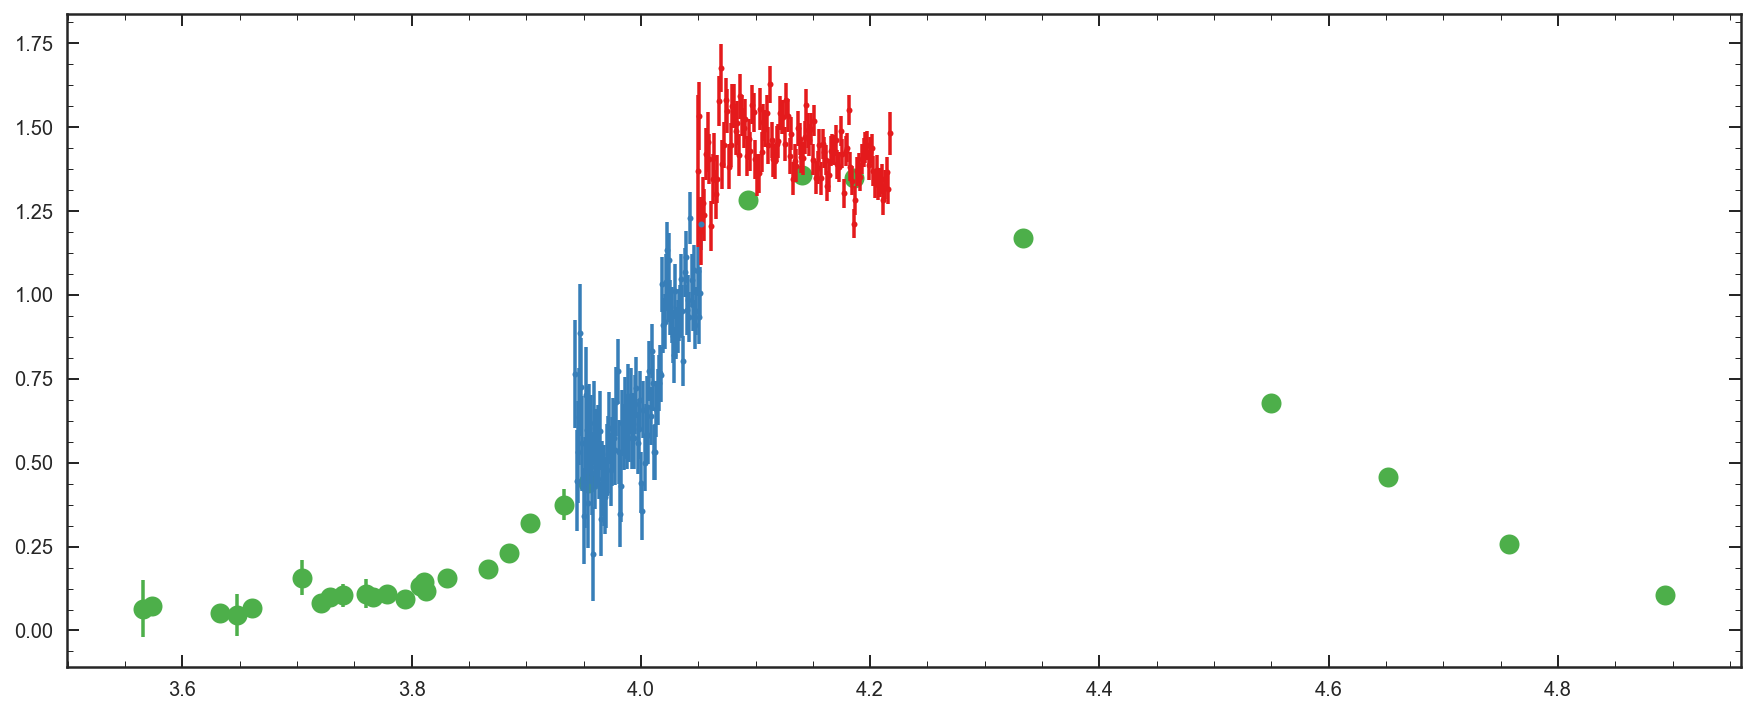

In [187]:
plt.figure(figsize=[15,6])
plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl*1E18,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

In [9]:
from spec_tools import Oldest_galaxy

In [6]:
Oldest_galaxy(1.45)

4.535936166227886

## Set Prior and Likelihood

In [185]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 4, tau = 0.1, dust_type = 1)

############
###priors###
def alma_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (3 - 1)* u[1] + 1
    bsc= Gaussian_prior(u[2], [0.8, 1.2], 1, 0.05)
    rsc= Gaussian_prior(u[3], [0.8, 1.2], 1, 0.05)
    bp1 = Gaussian_prior(u[4], [-0.1,0.1], 0, 0.05)
    rp1 = Gaussian_prior(u[5], [-0.05,0.05], 0, 0.025)
    
    lm = Gaussian_prior(u[6], [9.5, 12.5], 11, 0.75)
       
    z = stats.norm.ppf(u[7],loc = 1.6, scale = 0.1)
    
    d = log_10_prior(u[8],[1E-3,2])
    
    t = log_10_prior(u[9],[0.01, 2])

    return [m, a, bsc, rsc, bp1, rp1, lm, z, d, t]
############
#likelihood#
def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

def Full_calibrate(Gmfl, p1):
    for i in range(len(wvs)):
        Gmfl[i] = Gmfl[i] * ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
    return Gmfl

def Full_calibrate_2(Gmfl, p1, sc):
    for i in range(len(wvs)):
        rGmfl= Gmfl[i] * (p1[i] * (wvs[i] -(wvs[i][-1] + wvs[i][0])/2 ) + 1E3)
        scale = Scale_model(Gmfl[i],np.ones_like(Gmfl[i]),rGmfl)
        Gmfl[i] = scale * rGmfl * sc[i]
    return Gmfl

def Calibrate_grism(spec, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))

    return Gchi, Pchi

def Full_fit_2(spec, Gmfl, Pmfl, a, b, l): 
    Gln = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        noise = noise_model(np.array([wvs[i],flxs[i], errs[i]]).T, Gmfl[i] * scale)
        noise.GP_exp_squared(a[i],b[i],l[i])
        Gln += noise.gp.lnlikelihood(noise.diff)

    Pln = lnlike_phot(spec.Pflx, spec.Perr, Pmfl)
    
    return Gln + Pln

def Full_fit_3(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        Gchi = Gchi + np.sum( ((flxs[i] - Gmfl[i]) / errs[i] )**2 )
    
    Pchi = np.sum( ((spec.Pflx - Pmfl) / spec.Perr)**2)

    return Gchi, Pchi

# wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

def alma_L(X):
    m, a, bsc, rsc, bp1, rp1, lm, z, d, t = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['tau'] = t
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux, wave*(1+z) , z, 0, sp.stellar_mass)*10**lm, z)
       
    Gmfl = Full_calibrate_2(Gmfl, [bp1, rp1], [bsc, rsc])

    Gchi, Pchi = Full_fit_3(Gs, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)


In [190]:
sampler = dynesty.NestedSampler(alma_L, alma_prior, ndim = 10, sample = 'rwalk', bound = 'single',
                                  queue_size = 8, pool = Pool(processes=8))  

Process ForkPoolWorker-10:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:


Exception while calling loglikelihood function:
  params: [1.56412486e+00 2.05052905e+00 9.62308256e-01 1.01044549e+00
 1.01212633e-02 3.34878322e-03 1.02492602e+01 1.72323421e+00
 9.40016473e-02 2.55295240e-02]
  args: []
Exception while calling loglikelihood function:
  kwargs: {}
  exception:
  params: [ 9.01366698e-01  2.40445539e+00  9.52026279e-01  1.02322224e+00
  2.55049745e-02 -1.45967103e-02  1.21511428e+01  1.85529865e+00
  5.57733906e-03  7.47783450e-02]Exception while calling loglikelihood function:



Traceback (most recent call last):


  args: []


  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-185-61ebece35fea>", line 100, in alma_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)


  kwargs: {}
  exception:


  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 591, in get_spectrum
    NSPEC = driver.get_nspec()
KeyboardInterrupt
Process ForkPoolWorker-12:
Traceback (most recent call last):


Exception while calling loglikelihood function:


  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-185-61ebece35fea>", line 100, in alma_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 582, in get_spectrum
    self._compute_csp()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 546, in _compute_csp
    driver.compute_zdep(NSPEC, NTFULL, self._zcontinuous)
KeyboardInterrupt


  params: [ 1.12099879e+00  2.05101627e+00  9.11502162e-01  8.97185345e-01
 -7.52319312e-02  3.89480041e-03  1.09586620e+01  1.59106299e+00
  7.34124497e-03  3.94646087e-01]
  params: [1.41744237e+00 1.61568583e+00 9.54266652e-01 1.00219035e+00
 6.05386382e-02 1.50233829e-02 1.11724817e+01 1.62448506e+00
 6.19053898e-03 1.10593272e+00]
  args: []
  args: []
  kwargs: {}
  kwargs: {}
  exception:
  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-185-61ebece35fea>", line 100, in alma_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
  File "<ipython-input-185-61ebece35fea>", line 100, in alma_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 582, in get_spectrum
    self._compute_csp()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 582, in get_spectrum


In [191]:
# sampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True,)
sampler.run_nested(print_progress=True)

dres = sampler.results

iter: 584 | bound: 0 | nc: 5 | ncall: 1579 | eff(%): 36.985 | loglstar:   -inf < -142915.322 <    inf | logz: -142923.396 +/-  0.127 | dlogz: 141848.406 >  0.509                                     

KeyboardInterrupt: 

(<Figure size 864x1944 with 18 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7d044cf8>,
       dtype=object))

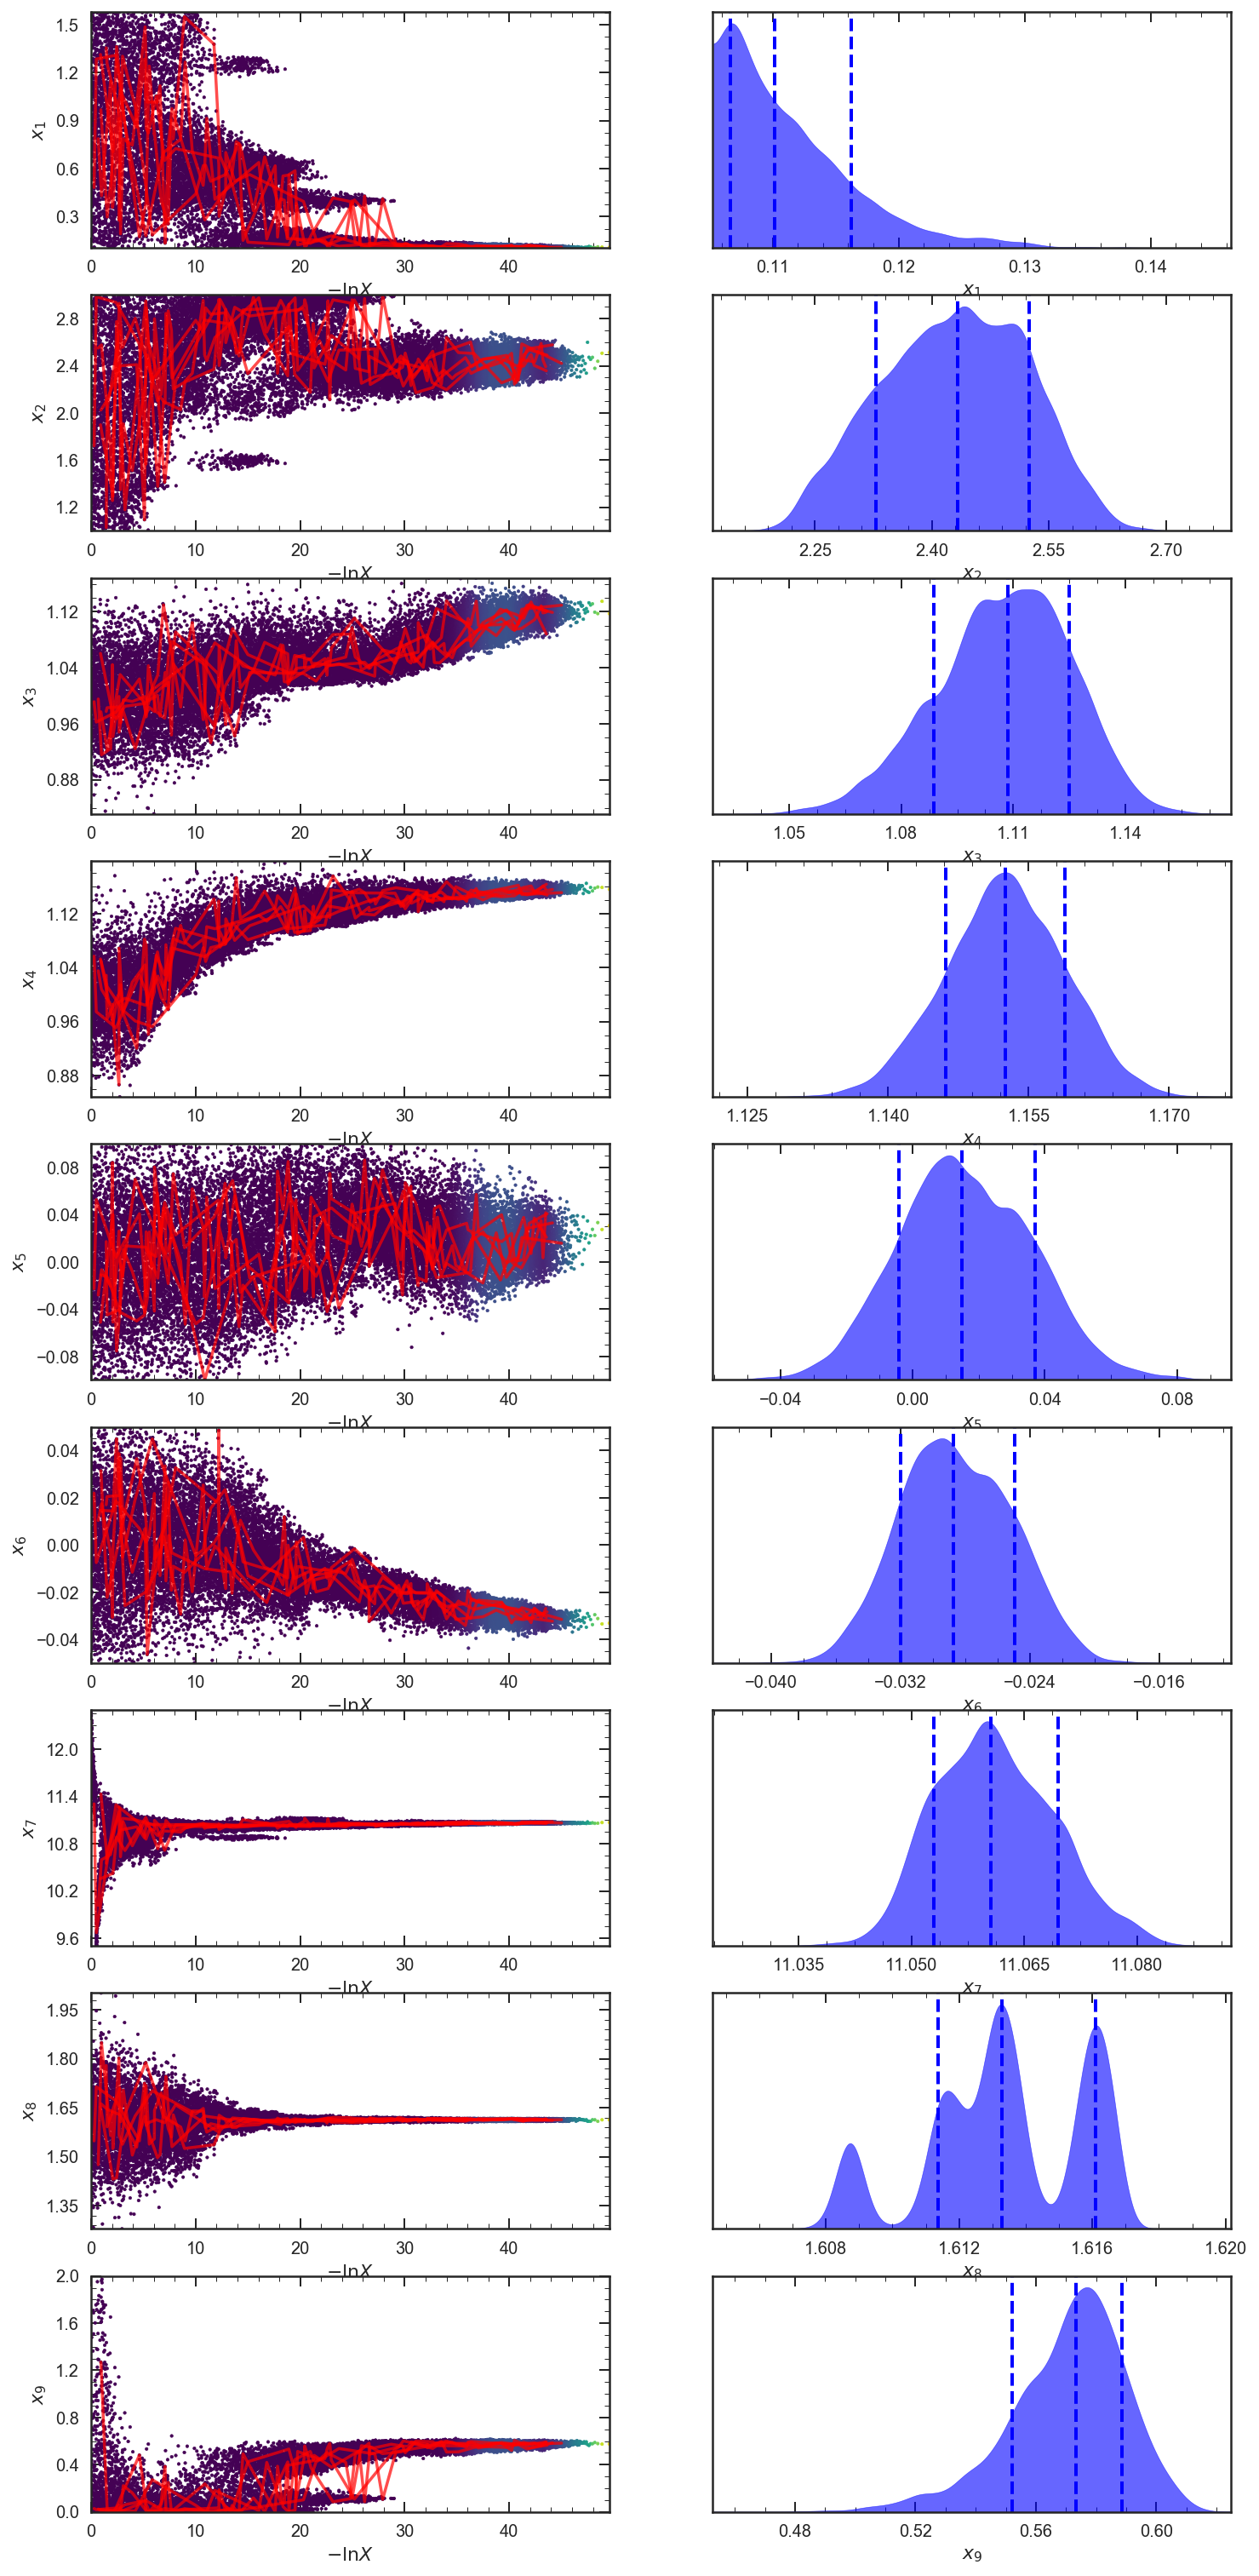

In [98]:
dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

In [99]:
def Calibrate_grism(spec, Gmfl, p1):
    lines = (p1 * (spec[0] -(spec[0][-1] + spec[0][0])/2 ) + 1E3)
    scale = Scale_model(spec[1]  / lines, spec[2] / lines, Gmfl)    
    return scale * lines

In [100]:
m, a, bsc, rsc, bp1, rp1, lm, z, d = dres.samples[-1]

sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)


wave, flux = sp.get_spectrum(tage = a, peraa = True)

Pmfl = Gs.Sim_phot_mult(wave * (1 + z),F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)   

Bmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + z), 
                               F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)
bscale = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Bmfl, bp1)

Rmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + z), 
                               F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)
rscale = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Rmfl, rp1)

([<matplotlib.axis.XTick at 0x1a8283bbe0>,
 <a list of 5 Text xticklabel objects>)

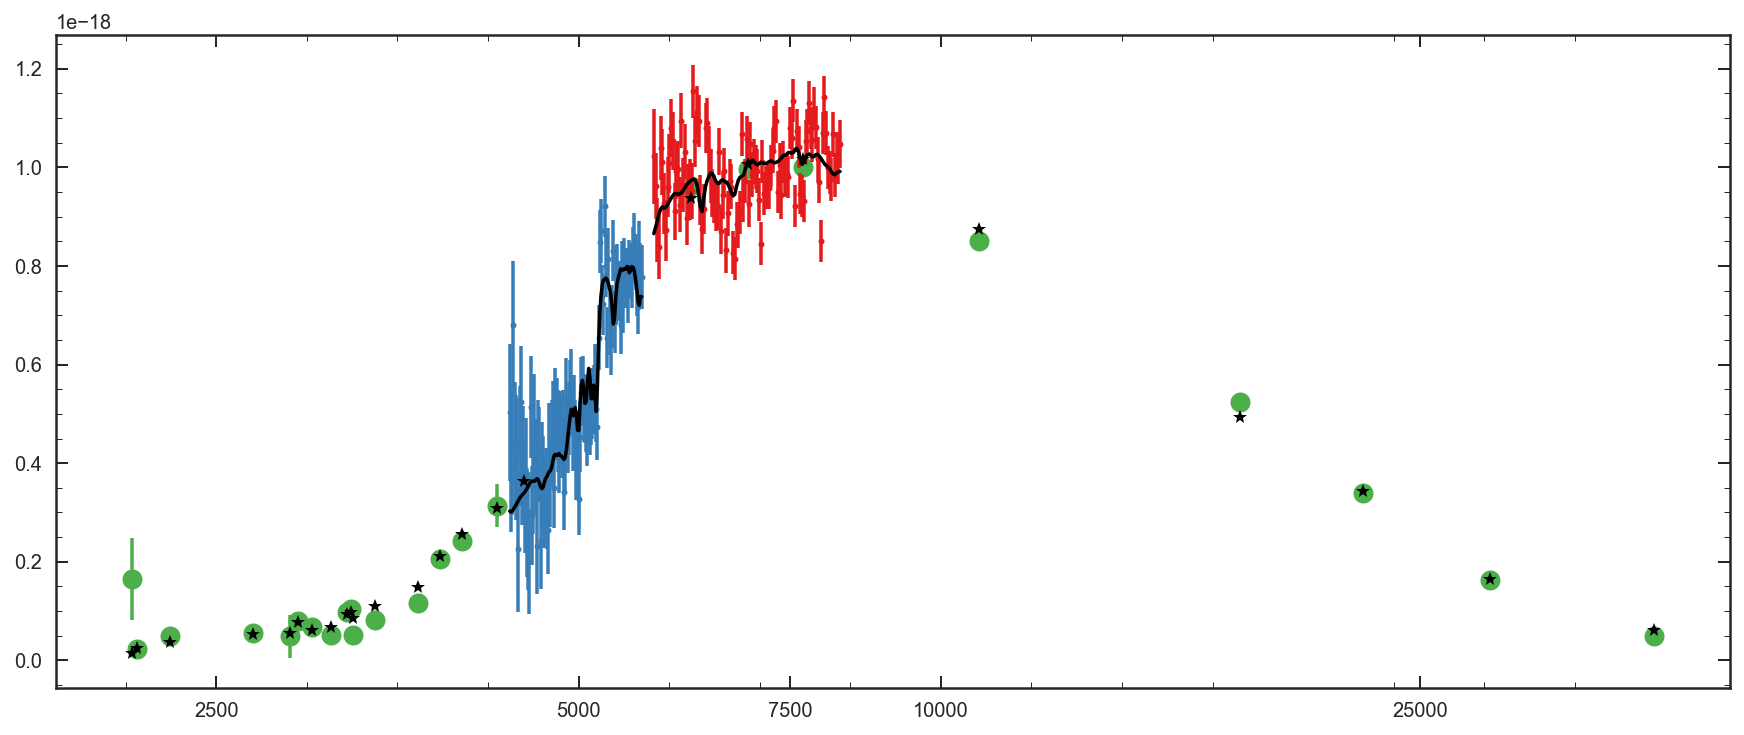

In [101]:
plt.figure(figsize = [15,6])

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl / (bscale),Gs.Ber / (bscale),
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl / (rscale),Gs.Rer / (rscale),
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
plt.plot(np.log10(Gs.Bwv_rf), Bmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Rmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Pmfl, 'k*' , zorder=5)

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

In [13]:
def Get_posterior(results, entry):
    sample = results.samples[:, entry]
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [14]:
z,Pz = Get_posterior(dres,2)

(1.5, 1.7)

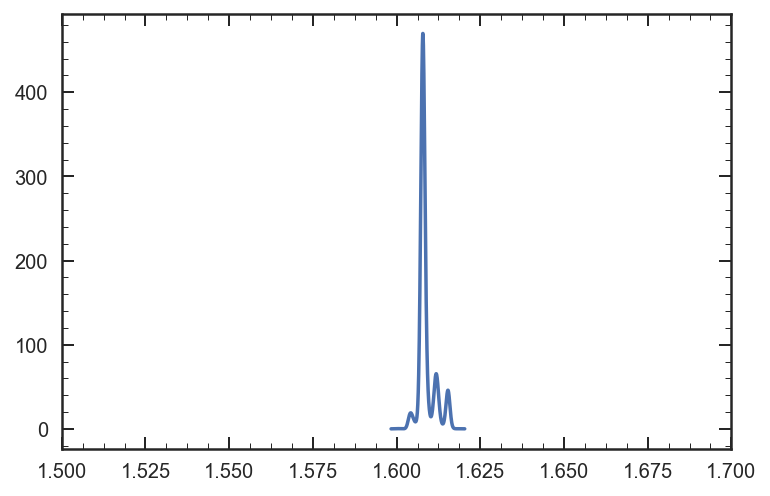

In [21]:
plt.plot(z,Pz)
plt.xlim(1.5,1.7)

In [4]:
from spec_stats import Highest_density_region

In [24]:
Highest_density_region(Pz,z)

(1.607836490056423, 0.001024534379777231, 0.0011455493073775358)

In [22]:
dres.samples[-1]

array([0.57975329, 4.49953077, 1.60797278])

In [23]:
sp.params['logzsol'] = np.log10( 0.57975 )

wave, flux = sp.get_spectrum(tage = 4.5, peraa = True)

In [25]:
Gs.Sim_all_premade(wave * (1 + 1.60797),flux)

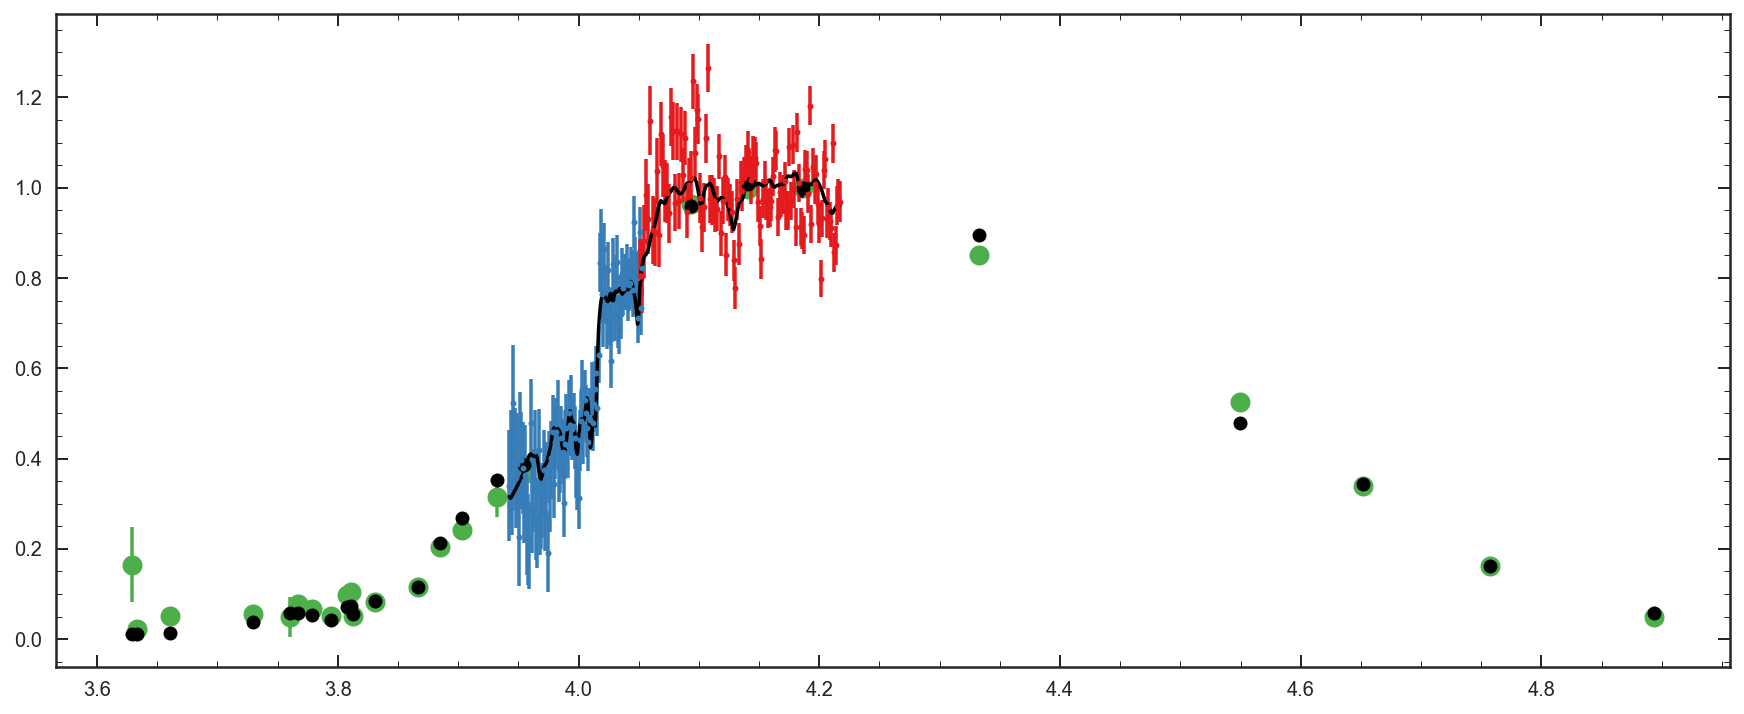

In [26]:
plt.figure(figsize=[15,6])
plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl*1E18,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.plot(np.log10(Gs.Bwv),Gs.Bmfl*1E18,'k')
plt.plot(np.log10(Gs.Rwv),Gs.Rmfl*1E18,'k')
plt.plot(np.log10(Gs.Pwv),Gs.Pmfl*1E18,'ko')

# P(z)

In [19]:
IDS = v4S.id[SQ_up].values; RA =  v4S.ra[SQ_up].values; DEC =v4S.dec[SQ_up].values

In [40]:
Lmass = np.log10(v4S.mass[SQ_up].values)
LmassF = v4S.lmass[SQ_up].values

In [181]:
Lmass, LmassF

(array([10.87714134, 10.6141395 , 10.60324485, 11.28851378, 11.33595205,
        10.95357578, 11.21386444, 11.48012703, 11.30366194, 10.05558077,
        11.35525565]),
 array([10.51, 10.39, 10.35, 11.09, 11.12, 10.66, 10.92, 11.18, 10.96,
         9.76, 11.02]))

[1.56427866] 26272 53.150826 -27.790601
[1.66000791] 29257 53.147471 -27.777637
[1.61242367] 38843 53.107039 -27.729749
[1.56086324] 39012 53.06424 -27.727621
[1.61120808] 39364 53.062821 -27.726461
[1.59919172] 40223 53.124956 -27.722957
[1.60854213] 41520 53.152726 -27.716251
[1.61531838] 42113 53.151174 -27.713724
[1.59378246] 42778 53.149594 -27.711374
[1.60633113] 43007 53.146974 -27.709766
[1.61568211] 44042 53.10457 -27.705421


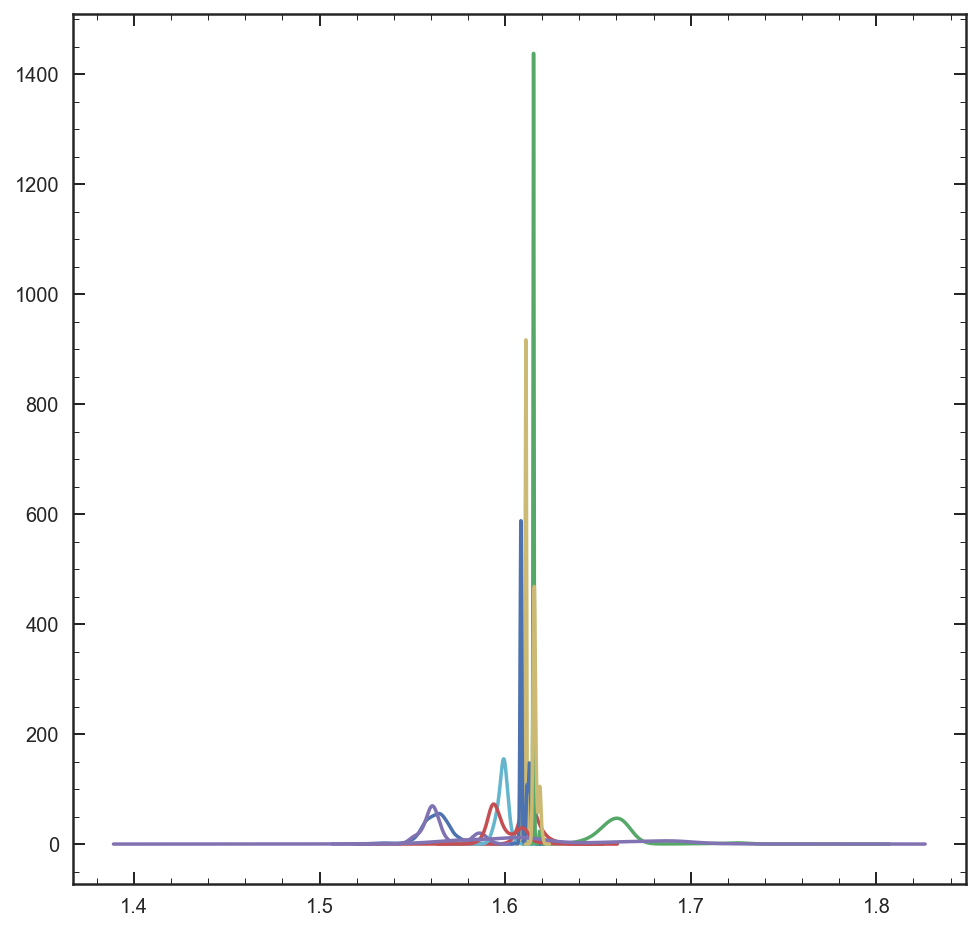

In [38]:
pzs = glob('../data/posteriors/ALMA_*Pz*')
Z=[]
plt.figure(figsize=[8,8])
for i in range(len(pzs)):
    z,pz = np.load(pzs[i])
    print(z[pz == max(pz)], IDS[i],RA[i],DEC[i])
    Z.append(z[pz == max(pz)][0])
    plt.plot(z,pz)

In [43]:
gals = [26272, 29257, 38843, 39012, 39364, 40223, 41520, 42113, 42778,43007, 44042]

LIMSR = [None, None, None, None, None, [11200,12500], None, [11200,15400], [14000,16500], None, None]

In [21]:
gals = [39364, 40223, 41520, 42113, 42778, 44042]

In [22]:
from spec_stats import Highest_density_region

39012
39364
40223
41520
42113
42778
44042


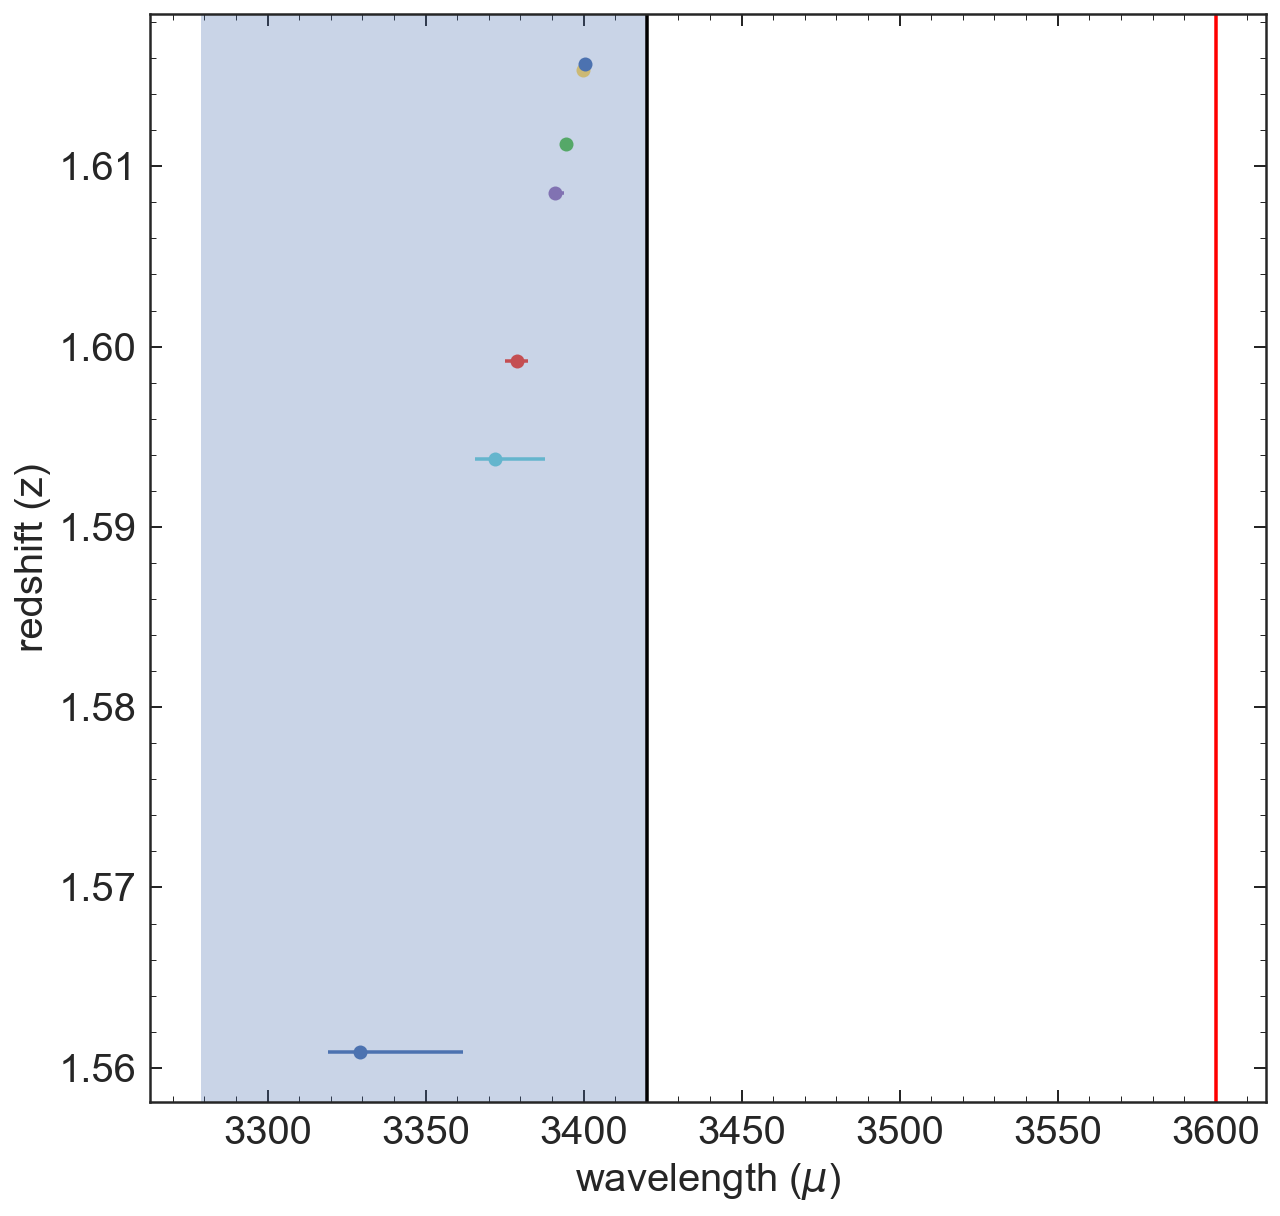

In [25]:

co12 = 1300 # micron

plt.figure(figsize=[10,10])
for i in range(len(gals)):
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(gals[i]))
    rshift, rl, rh = Highest_density_region(pz,z)

    loc = co12 * (1 + rshift)

    plt.errorbar(loc , rshift, xerr=[[loc - co12 * (1 + rshift - rl)],[co12 * (1 + rshift + rh) - loc]], fmt='o' )
    print(gals[i])
plt.axvspan(3279,3420,alpha = 0.3)

plt.axvline(3600, color='r')
plt.axvline(3420, color='k')

plt.xlabel('wavelength ($\mu$)', fontsize=20)
plt.ylabel('redshift (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/alma_window.png' ,bbox_inches = 'tight')

In [31]:
3E8 / 3420E-6 * 1E-9 + 1.875 * 2

91.46929824561406

In [32]:
3E8/87.589E9 * 1E6, 3E8/91.46929E9* 1E6

(3425.08762515841, 3279.7893150805044)

39012
39364
40223
41520
42113
42778
44042


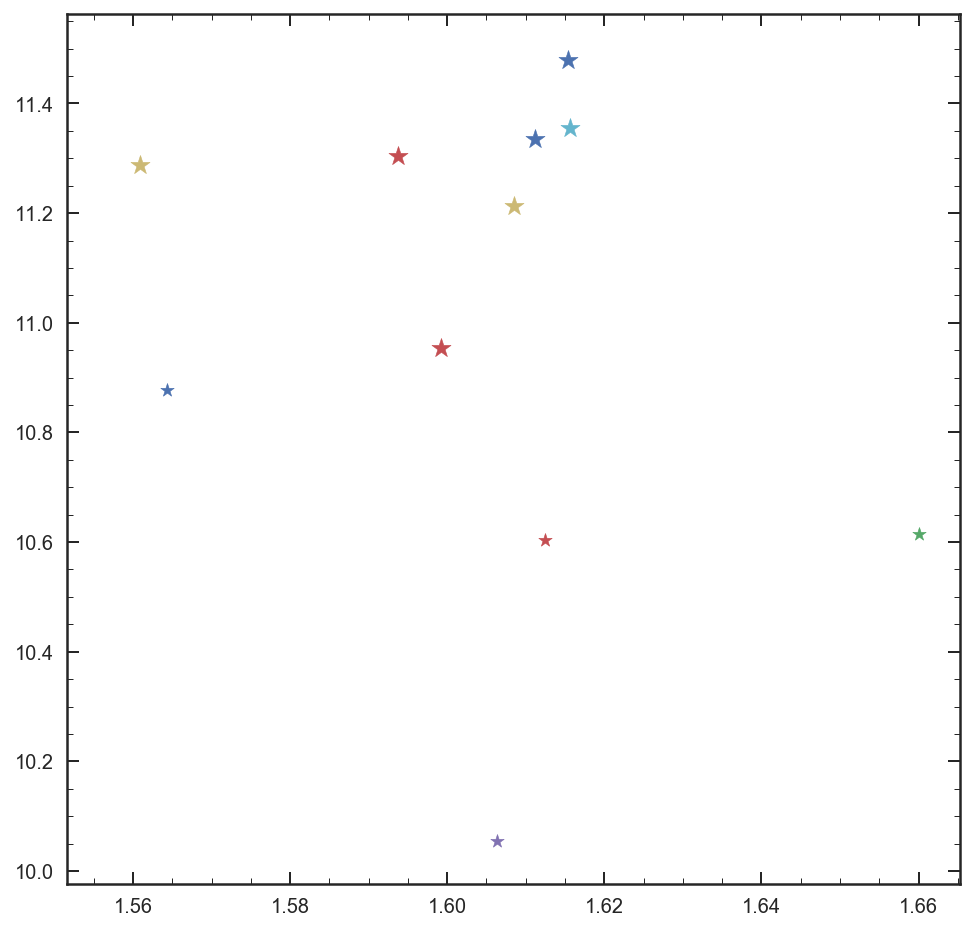

In [26]:
plms = glob('../data/posteriors/ALMA_*_Plm.npy')
pzs = glob('../data/posteriors/ALMA_*_Pz.npy')

plt.figure(figsize=[8,8])
for i in range(len(pzs)):
    z,pz = np.load(pzs[i])
    m,pm = np.load(plms[i])
                  
    rshift, rl, rh = Highest_density_region(pz,z)
    lmass, ll, lh = Highest_density_region(pm,m)
    
#     plt.errorbar(rshift,lmass, yerr = [[rl],[rh]], xerr = [[ll],[lh]])
    plt.scatter(rshift,Lmass[i], marker = '*')  
#     plt.plot(rshift,LmassF[i], 'o')       

    if 10**10.2 /10**Lmass[i] < 0.2:
        print(IDS[i])
        plt.scatter(rshift,Lmass[i], marker = '*', s = 100)  


In [3]:
import numpy as np

# Settings for ALMA from Benzanson 2019

base line 330 m at a resolution of 2"

total duration of the two observing blocks was 160 min, with 109 min on source

target galaxy - 

steallar mass  - log($M_*/M_\odot$) = 11.2

gas mass upper limit of -log($M_{H_2}/M_\odot$) = 10.04

gas fraction of $M_{H_2}/M_*$ < 7 %

In [4]:
np.log10(1.1E10)

10.041392685158225

In [74]:
1300/30

43.333333333333336

In [114]:
1/2, 1/2**2

(0.5, 0.25)

In [123]:
L_B = (10**11.2)**3.5; L_Bg = (10**10.04)**3.5; L_Bg5 = (10**9.9)**3.5

In [124]:
L_B/L_Bg, L_B/L_Bg5

(11481.536214968837, 35481.33892335723)

In [122]:
np.log10(10**11.2*0.05)

9.898970004336018

In [142]:
L_t = (10**np.log10(10**11.1*0.07))**3.5

In [143]:
1/(L_t / L_Bg)**2

4.61650935434528

In [144]:
L_t / L_Bg

0.4654179619277193

In [145]:
10**10.2/10**11.1

0.12589254117941662

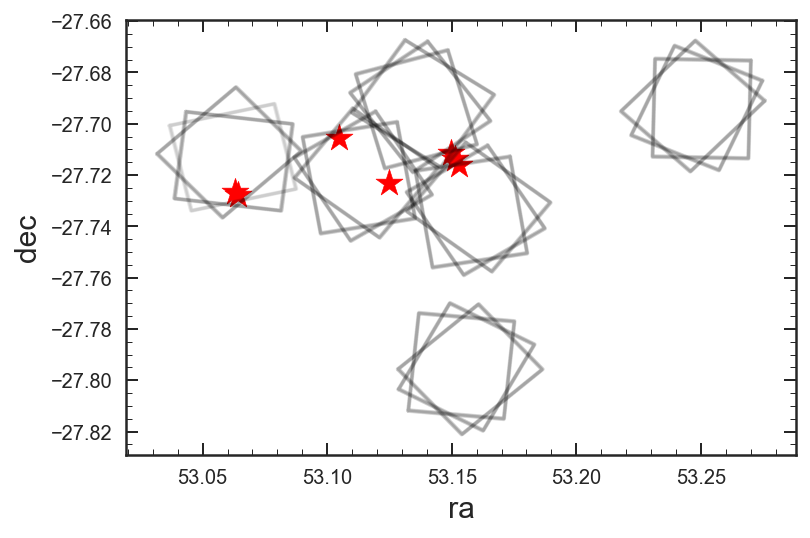

In [37]:
gals = [39012, 39364, 40223, 41520, 42113, 42778, 44042]
for i in range(len(allpos)):
    plt.plot(allpos[i][0],allpos[i][1], 'k',alpha = 0.05,zorder=1)

for i in gals:
    # plt.scatter(v4S.ra[SQ_up],v4S.dec[SQ_up],marker='*', s=200, color = 'b')        
    plt.scatter(v4S.ra[i - 1],v4S.dec[i - 1],marker='*', s=200, color = 'r')
    plt.xlabel('ra', fontsize=15)
    plt.ylabel('dec', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)

In [194]:
10**10 / 4.4 / 1E9

2.2727272727272725

In [42]:
IDS,Z,RA,DEC,Lmass

(array([26272, 29257, 38843, 39012, 39364, 40223, 41520, 42113, 42778,
        43007, 44042]),
 [1.5642786573275431,
  1.660007908668116,
  1.6124236678704493,
  1.5608632361631087,
  1.6112080798277324,
  1.5991917243125393,
  1.60854213012882,
  1.6153183776258682,
  1.5937824593517413,
  1.606331125847705,
  1.6156821069173826],
 array([53.150826, 53.147471, 53.107039, 53.06424 , 53.062821, 53.124956,
        53.152726, 53.151174, 53.149594, 53.146974, 53.10457 ]),
 array([-27.790601, -27.777637, -27.729749, -27.727621, -27.726461,
        -27.722957, -27.716251, -27.713724, -27.711374, -27.709766,
        -27.705421]),
 array([10.87714134, 10.6141395 , 10.60324485, 11.28851378, 11.33595205,
        10.95357578, 11.21386444, 11.48012703, 11.30366194, 10.05558077,
        11.35525565]))

In [46]:
gid,gz,gra,gdec,glmass = [[],[],[],[],[]]

Ggals = [39012, 39364, 40223, 41520, 42113, 42778, 44042]

for i in range(len(gals)):
    if gals[i] in Ggals:
        print(IDS[i])
        gid.append(IDS[i])
        gz.append(Z[i])        
        gra.append(RA[i])        
        gdec.append(DEC[i])        
        glmass.append(Lmass[i])        
        

39012
39364
40223
41520
42113
42778
44042


In [48]:
DB = pd.DataFrame({'id':gid,'z':np.round(gz,4),'ra':gra,'dec':gdec,'lmass':glmass})

In [51]:
DB = DB[['id','ra','dec','z','lmass']]

In [53]:
DB.to_csv('../dataframes/ALMA_sources.dat', sep=' ', index=False)

In [34]:
DB = pd.read_csv('../dataframes/ALMA_sources.dat',sep=' ')

In [43]:
goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [70]:
Reff = []
Rpc = []
for i in DB.index:   
    r = goodss_rad.re[goodss_rad.NUMBER == DB.id[i]].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == DB.id[i]].values)
    Reff.append(r[0])
    Rpc.append(r[0] /cosmo.arcsec_per_kpc_comoving(DB.z[i]).value *1E3)


In [71]:
Reff, Rpc

([0.2262255723203157,
  0.1990958100924678,
  0.126624840656004,
  0.1415528966769158,
  0.239719076272547,
  0.25776491228354803,
  0.26994932795341425],
 [5035.538767217672,
  4519.121002638338,
  2861.0183919705473,
  3209.701845019548,
  5449.661595927658,
  5811.965017239317,
  6137.830923532796])

In [ ]:
0.1990958100924678,


In [56]:
DB['rpc'] = Rpc

## Calculate luminosity

#### get L'(co)

$\alpha = \frac{M_g}{L'(co)}$


$L'(co) = \frac{0.05 M_* }{4.3}$

In [2]:
def Lco(logmass):
    return (10**logmass * 0.05)/ 4.3

#### get S$_{line} \Delta v$

$L'(co) = 3.25 \times 10^7 \times S_{line} \Delta v \frac{D^2_L}{(1+z)^3 \nu^2_obs}$

$S_{line} \Delta v  = L'(co) / (3.25 \times 10^7 \times \frac{D^2_L}{(1+z)^3 \nu^2_{obs}})$  $Jy \: km \: s^{-1}$

In [3]:
def get_lineflux(logmass, redshift):
    top = Lco(logmass)
    nu_obs = 115.3 / (1+redshift) # frequency of 1-0 in Ghz
    bt = 3.25E7 * cosmo.luminosity_distance(redshift).value**2 / ((1+redshift)**3 * nu_obs**2)
    
    return top / bt

### estimate 2-1

from daddi 2015

CO(2-1) ~ 3 * CO(1-0)

In [4]:
def get_2to1_flux(logmass, redshift):
    return 3 * get_lineflux(logmass, redshift)

In [12]:
print(get_lineflux(11.34, 1.2))

0.03166223325190547


In [11]:
print(get_2to1_flux(11.34, 1.61))
print(get_2to1_flux(11.34, 1.2))

0.054615975082525775
0.0949866997557164


In [10]:
np.log10(2.2E11)

11.342422680822207

In [84]:
for i in DB.index:
    print(get_2to1_flux(DB.lmass[i], DB.z[i]))
#     print(Lco(DB.lmass[i])*1E-9)
    

0.05136419104079454
0.05403510589064177
0.022713308233177545
0.04091942563395533
0.07495824753131029
0.05117700417960738
0.056201792382955015


## Calculate velocity

assume $v = \sqrt{\frac{2GM}{r}}$

G ≈ 6.67×10−11 $m^3kg^{−1}s^{−2}$

$\frac{3.086 \times 10^{16} m }{1 pc}$

$\frac{2 \times 10^{30} kg }{1 M_\odot}$


In [58]:
pc_to_m = 3.086E16
msol_to_kg =  2E30
G = 6.67E-11

In [75]:
def get_v(logmsol, rpc):
    M = 10**logmsol * msol_to_kg
    r = rpc * pc_to_m
    return np.sqrt(G*M/r) * 1E-3 # km /s

In [76]:
for i in DB.index:
    print(get_v(DB.lmass[i], DB.rpc[i]))

408.42646098961825
455.3328619394066
368.4745676906722
469.43971508224723
489.50676674920976
386.85608052423044
399.484853568812


In [79]:
DB[['id','z', 'ra', 'dec', 'lmass']]

id       z         ra        dec      lmass
0  39012  1.5609  53.064240 -27.727621  11.288514
1  39364  1.6112  53.062821 -27.726461  11.335952
2  40223  1.5992  53.124956 -27.722957  10.953576
3  41520  1.6085  53.152726 -27.716251  11.213864
4  42113  1.6153  53.151174 -27.713724  11.480127
5  42778  1.5938  53.149594 -27.711374  11.303662
6  44042  1.6157  53.104570 -27.705421  11.355256

In [87]:
for i in DB.index:
    print(10**DB.lmass[i] *1E-11)

1.9431833404540002
2.16746479505818
0.8986193743426439
1.6363056922618175
3.0208351536094242
2.0121573459700266
2.2659777884928722


In [41]:
perc=[]
for i in range(len(gals)):
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(gals[i]))
    med ,le ,he = Highest_density_region(pz,z)
    perc.append((le / (1+med) + he / (1+med)) / 2 * 100)

In [45]:
np.median(perc)

0.055154092907626524

In [9]:
for i in range(len(gals)):
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(gals[i]))
    med ,le ,he = Highest_density_region(pz,z)
    print(np.round([le ,he],4))

[0.0078 0.0251]
[0.0005 0.0004]
[0.0029 0.0026]
[0.0008 0.0021]
[0.0003 0.0003]
[0.0048 0.0121]
[0.0009 0.0011]


In [24]:
img_set = []
for i in gals:
    idx = np.argwhere(seg == i)

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = seg[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img = f105[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img[segimg != i] = 0
    maxloc = np.argwhere(f105img == np.max(f105img))[0]

    ycnt = ylist[maxloc[0]]
    xcnt = xlist[maxloc[1]]

    f105img = f105[ycnt - 13: ycnt + 13, xcnt - 13: xcnt + 13]
    f125img = f125[ycnt - 13: ycnt + 13, xcnt - 13: xcnt + 13]
    f160img = f160[ycnt - 13: ycnt + 13, xcnt - 13: xcnt + 13]


    img = np.zeros((f125img.shape[0], f125img.shape[1], 3), dtype=float)
    img[:,:,0] = img_scale.asinh(f160img, scale_min=-0.1, scale_max=0.5)
    img[:,:,1] = img_scale.asinh(f125img, scale_min=-0.1, scale_max=0.5)
    img[:,:,2] = img_scale.asinh(f105img, scale_min=-0.1, scale_max=0.5)

    img_set.append(img)


img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh
img_scale : asinh


In [25]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

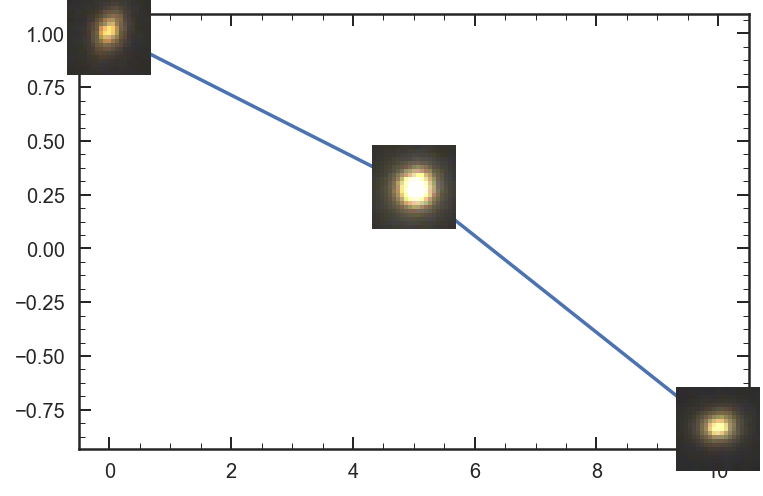

In [59]:
x = np.linspace(0, 10, 3)
y = np.cos(x)

fig, ax = plt.subplots()
for i in range(len(x)):
    imscatter(x[i], y[i], img_set[i], zoom=2, ax=ax)
ax.plot(x, y)
plt.show()

In [26]:
insample = np.repeat(False,len(v4S))

for i in v4S.index:
    if v4S.id[i] in gals:
        insample[i] = True

In [27]:
v4S['insample'] = insample

In [28]:
v4S_red = v4S.query('mass > 10**9.8 and 1.5 < z500 < 1.7 and use == 1 and star < 0.8')
v4S_q = v4S.query('insample == True')

In [31]:
GVJ.values, GUV.values

(array([1.02561559, 1.18429122, 1.20815239, 1.10254907, 1.58955236,
        1.05891962]),
 array([1.63433318, 1.79398561, 1.83411075, 1.88833659, 2.24292307,
        1.69299644]))

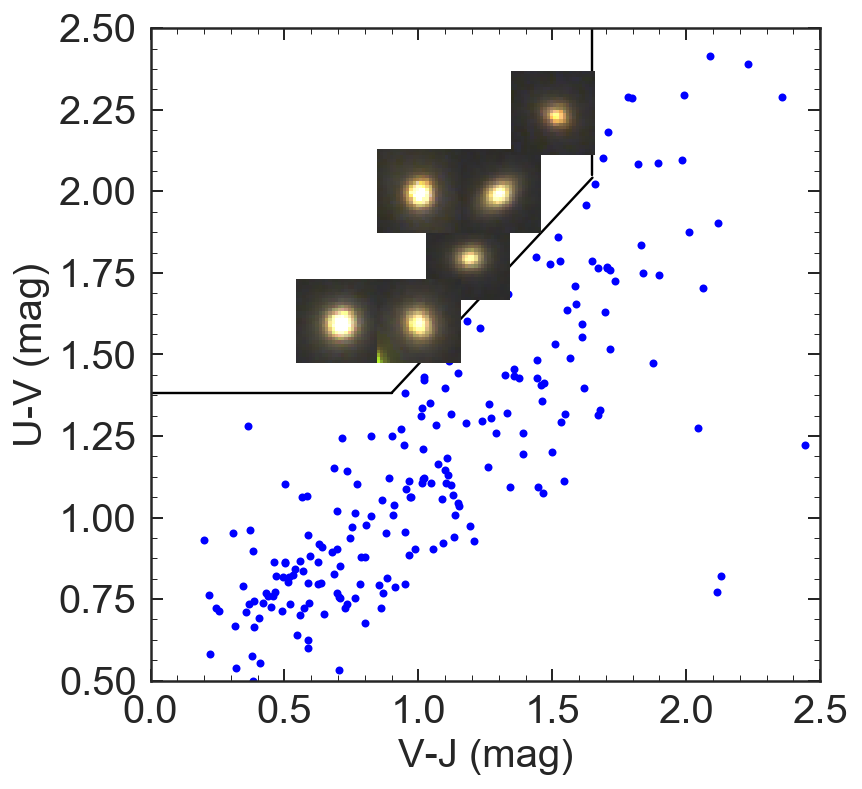

In [32]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

SQ = []
Ssf = []

for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)
    
GUV = Color(v4S_q.restU, v4S_q.restV)
GVJ = Color(v4S_q.restV, v4S_q.restJ)
        
fig, ax = plt.subplots(figsize=[6,6])

gvj = [0.7, 1.18429122, 1.3, 1.,
        1.5, 1.0]
guv = [1.6, 1.79398561, 2, 2,
        2.24, 1.6]

for i in range(len(gvj)):
    imscatter(gvj[i], guv[i], img_set[i], zoom=1.6, ax=ax)

ax.plot(SVJ[Ssf], SUV[Ssf],'bo',ms=4)

# plt.plot(GVJ, GUV,'ro',ms=4)

ax.plot([0,.9],[1.382,1.382],'k',lw=1.2)
ax.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
ax.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
ax.axis([0,2.5,.5,2.5])

plt.xlabel('V-J (mag)', fontsize=20)
plt.ylabel('U-V (mag)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/ALMA/UVJ.png' ,bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is depreca

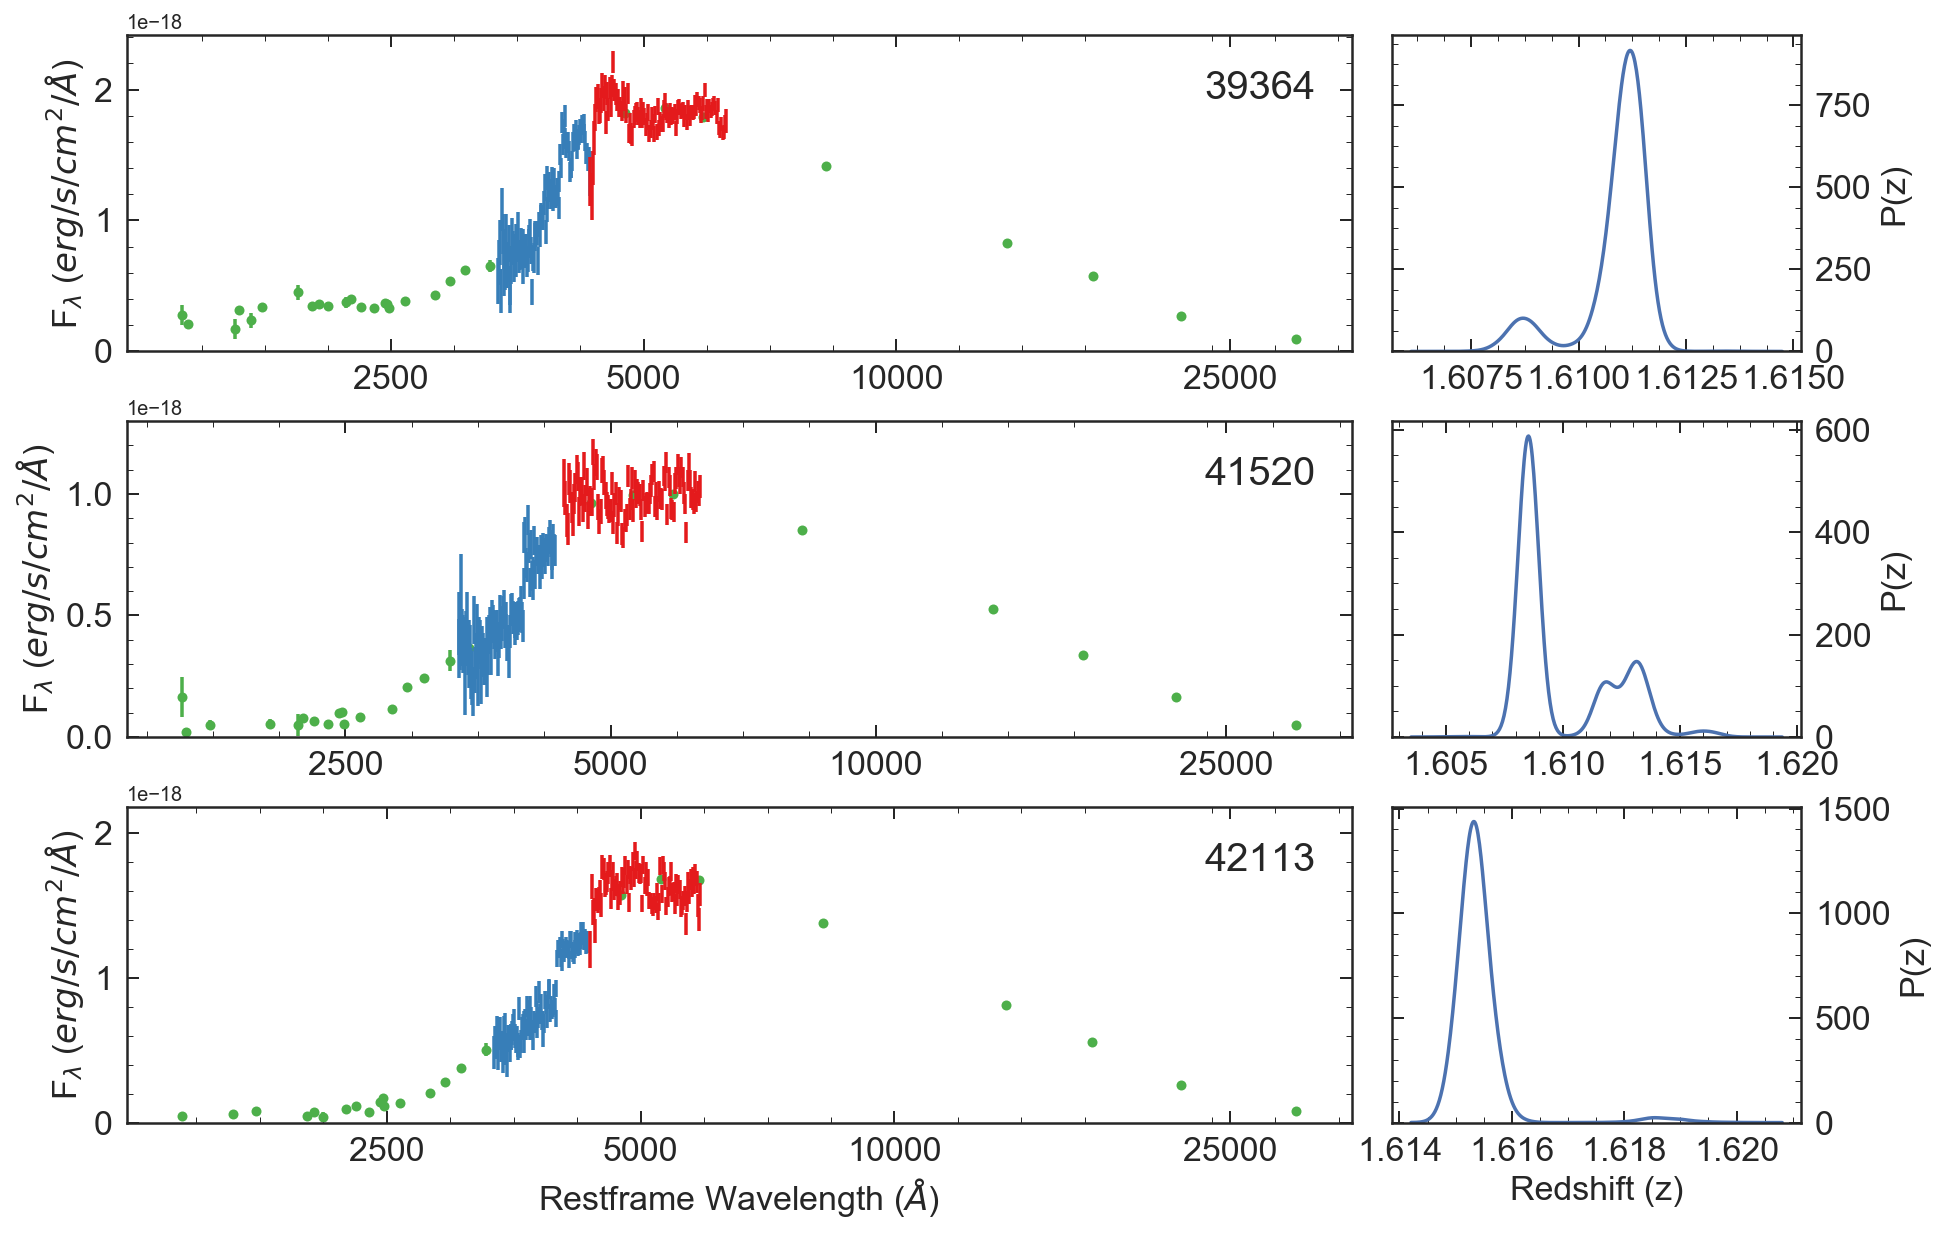

In [63]:
Gals = [39364,  41520, 42113]

LIMSR = [  None, None, [11200,15400]]
    
gs = GridSpec(3,2, hspace=0.22, width_ratios=[3,1], wspace=0.05)   

plt.figure(figsize=[15,10])

for i in range(len(Gals)):
    
    if LIMSR[i] == None:
        lim1 = 11200
        lim2 = 16500
    else:
        lim1 = LIMSR[i][0]
        lim2 = LIMSR[i][1]
      
    lims = [lim1,lim2]
    galaxy_id = Gals[i]
    
    m, a, bsc, rsc, bp1, rp1, lm, z, d, t, logl = np.load('../data/bestfits/ALMA_{0}_bfit.npy'.format(galaxy_id))

    Gs = Gen_ALMA_spec(galaxy_id, z, g102_lims=[8750,11300], g141_lims=[lims[0],lims[1]], mdl_err=False)
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 4, tau=0.1, dust_type = 1)

    wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux, wave*(1+z) , z, 0, 
                                                          sp.stellar_mass)*10**lm, z, wvs, flxs, errs, beams, trans)

    bscale = Calibrate_grism(wvs, flxs, errs, Gmfl, [bp1,rp1])

    plt.subplot(gs[i,0])
    
    plt.errorbar(np.log10(Gs.Bwv_rf), flxs[0] / bscale[0],errs[0] / bscale[0],
                    linestyle='None', marker='o', markersize=0, color='#377eb8',zorder = 2)
    plt.errorbar(np.log10(Gs.Rwv_rf), flxs[1] / bscale[1],errs[1] / bscale[1],
                    linestyle='None', marker='o', markersize=0, color='#e41a1c',zorder = 2)
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                    linestyle='None', marker='o', markersize=5, color='#4daf4a',zorder = 1)
    plt.plot([],[], 'o', color='#4daf4a',  label = galaxy_id)
    plt.xticks(np.log10([2500,5000, 10000, 25000]),[2500,5000, 10000,25000])
    plt.ylim(0,max(Gs.Pflx) * 1.3)            
    plt.legend(fontsize=20,markerscale = 0 )
    if i == 2:
        plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=17)
    plt.ylabel('F$_\lambda$ ($erg/s/cm^{2}/\AA $)', fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=17)

    ax = plt.subplot(gs[i,1])
    
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(Gals[i]))
    plt.plot(z,pz)
    
    if i == 2:
        plt.xlabel('Redshift (z)', fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=17)
    
    plt.gca().tick_params(axis='y',labelleft='off',labelright='on')
    plt.ylabel('P(z)', fontsize=17)
    ax.yaxis.set_label_position("right")
    plt.ylim(0,max(pz)*1.05)
    
plt.savefig('../plots/ALMA/all_ALMA_spec.png'.format(galaxy_id),bbox_inches = 'tight')

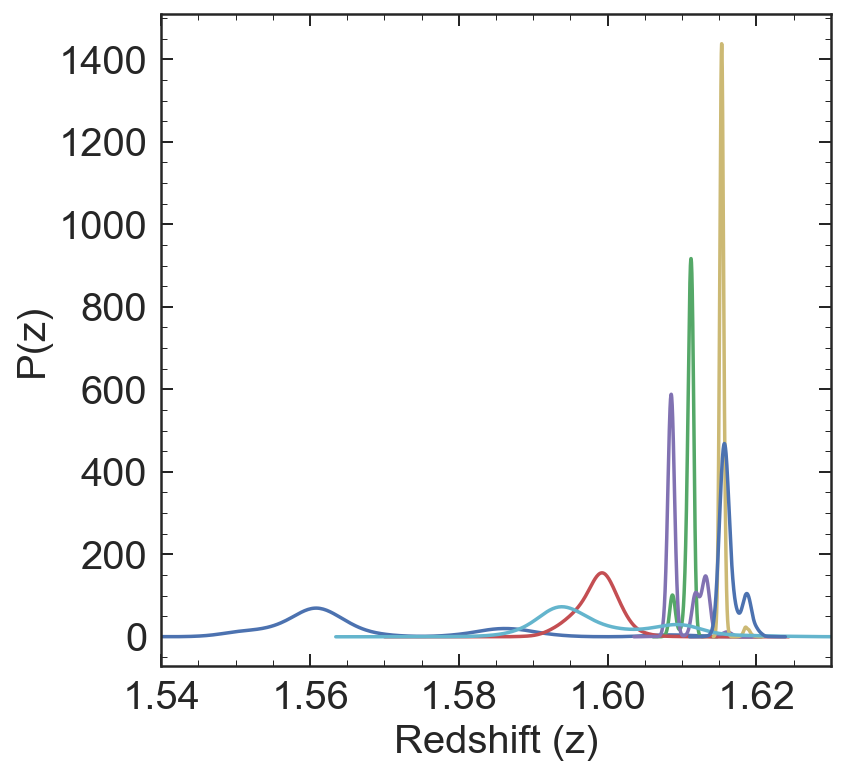

In [87]:
plt.figure(figsize=[6,6])
for i in range(len(gals)):
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(gals[i]))
    plt.plot(z,pz)
plt.xlim(1.54,1.63)

plt.xlabel('Redshift (z)', fontsize=20)
plt.ylabel('P(z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/ALMA/Pz.png' ,bbox_inches = 'tight')

2.4818925708291688e-14
no sfh
1.6551457857055606e-12
7.29981326494872e-13
no sfh
1.2864648079401422e-11


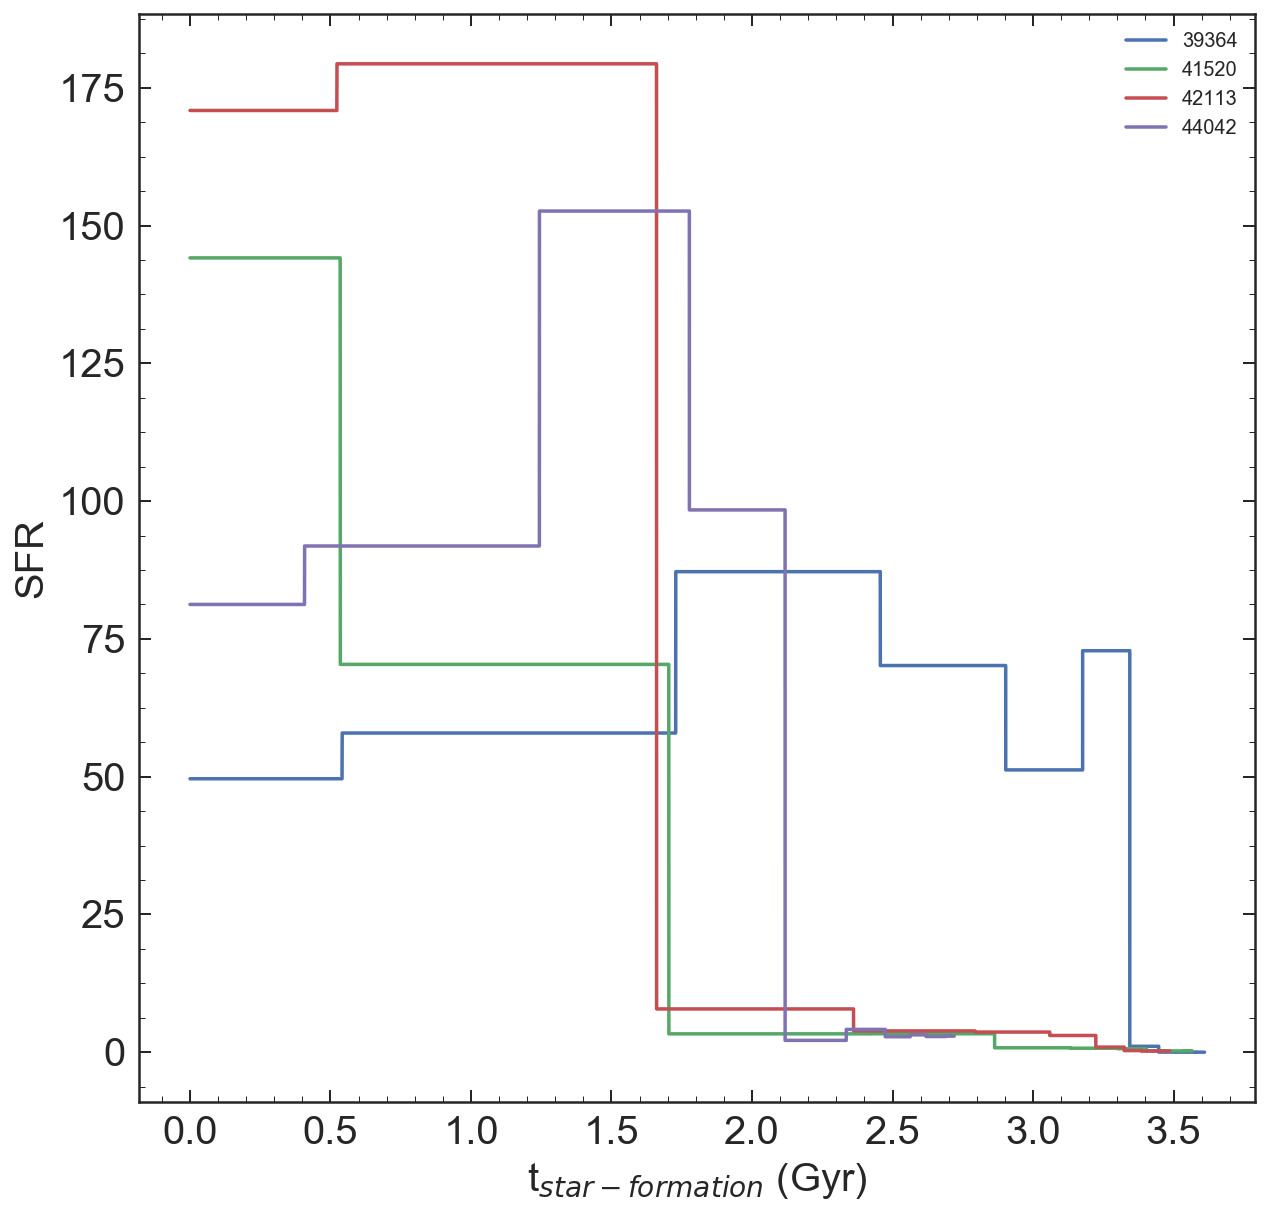

In [47]:
plt.figure(figsize = [10,10])
for i in range(len(gals)):
    try:
        med = np.zeros(10)
        for ii in range(10):
            x,px = np.load('../data/posteriors/GSD_{0}_tabfit_Pm{1}.npy'.format(gals[i], ii+1))
            med[ii] = x[px == px.max()][0]

        x,px = np.load('../data/posteriors/GSD_{0}_tabfit_Pa.npy'.format(gals[i]))
        a = x[px == px.max()][0]

        time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)

        plt.plot(time,sfr / np.trapz(sfr,time*1E9) * 10**Lmass[i], label = gals[i])
        print(np.array(sfr / np.trapz(sfr,time*1E9) * 10**Lmass[i])[-1] /10**Lmass[i] )
    except:
        print('no sfh')
        
plt.xlabel('t$_{star-formation}$ (Gyr)', fontsize=20)
plt.ylabel('SFR', fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/all_sfr.png' ,bbox_inches = 'tight')


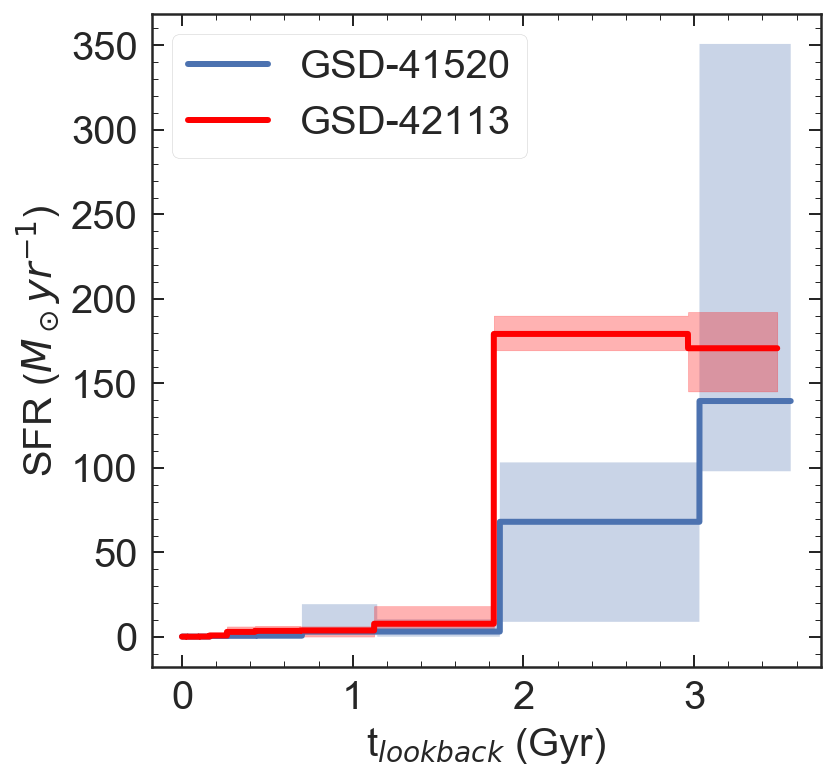

In [33]:
plt.figure(figsize = [6,6])

med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GSD_41520_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GSD_41520_tabfit_Pa.npy')
a = x[px == px.max()][0]

time1, sfr1, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time1, sfr_l1, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time1, sfr_h1, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)
####################
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GSD_42113_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GSD_42113_tabfit_Pa.npy')
a = x[px == px.max()][0]

time2, sfr2, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time2, sfr_l2, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time2, sfr_h2, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)
###################
plt.plot(max(time1) - time1,sfr1 / np.trapz(sfr1,time1*1E9) * 10**11.2 , linewidth=3, label = 'GSD-41520')
plt.fill_between(max(time1) - time1 ,sfr_l1/ np.trapz(sfr1,time1*1E9) * 10**11.2,
                 sfr_h1/ np.trapz(sfr1,time1*1E9) * 10**11.2, alpha = 0.3)

plt.plot(max(time2) - time2,sfr2 / np.trapz(sfr2,time2*1E9) * 10**11.48 , color = 'r', linewidth=3, label = 'GSD-42113')
plt.fill_between(max(time2) - time2 ,sfr_l2/ np.trapz(sfr2,time2*1E9) * 10**11.48,
                 sfr_h2/ np.trapz(sfr2,time2*1E9) * 10**11.48, color = 'r', alpha = 0.3)
        
plt.xlabel('t$_{look back}$ (Gyr)', fontsize=20)
plt.ylabel('SFR ($M_\odot yr^{-1}$)', fontsize=20)
plt.legend( fontsize=20, loc=2, frameon = True)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/ALMA/SFR.png' ,bbox_inches = 'tight')


In [35]:
goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()


In [132]:
for i in goodss_rad.index:
    if goodss_rad.NUMBER[i] in gals:
        print(goodss_rad.NUMBER[i], goodss_rad.n[i],goodss_rad.re[i] * np.sqrt(goodss_rad.q[i]))


39012 4.5309 0.2262255723203157
39364 3.2361 0.1990958100924678
40223 2.0646 0.126624840656004
41520 3.5081 0.1415528966769158
42113 7.2687 0.239719076272547
42778 5.6207 0.25776491228354803
44042 3.8145 0.26994932795341425


In [136]:
cosmo.age(1.61).value - 2

2.0211685659631318

In [142]:
cosmo.age(3.1)

<Quantity 2.07154846 Gyr>

In [16]:
np.log10(180 * 1E9)

11.255272505103306

In [11]:
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GSD_41520_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GSD_41520_tabfit_Pa.npy')
a = x[px == px.max()][0]

time1, sfr1, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time1, sfr_l1, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time1, sfr_h1, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

In [14]:
np.log10(np.trapz(sfr1 / np.trapz(sfr1,time1*1E9) * 10**11.2,time1*1E9))

11.2

In [34]:
MB = [0]
T=[0]
m=0
IMB = []
sfr = sfr2 / np.trapz(sfr2,time2*1E9) * 10**11.48
for i in range(len(time2)//2):
    m+=sfr[i*2+1] * (time2[i*2+1] - time2[i*2])*1E9
    IMB.append(sfr[i*2+1] * (time2[i*2+1] - time2[i*2])*1E9)
    MB.append(m)
    T.append(time2[i*2+1])

In [35]:
MB

[0,
 89238108923.50504,
 293085432288.22156,
 298584918352.8241,
 300252767168.32025,
 301224915340.8881,
 301722552947.9211,
 301815977460.5784,
 301834352741.2927,
 301848353698.23016,
 301854967760.8836]

In [36]:
np.log10(MB)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([       -inf, 10.95055036, 11.46699423, 11.47506787, 11.47748702,
       11.47889089, 11.47960777, 11.47974223, 11.47976867, 11.47978881,
       11.47979833])

In [37]:
sfr

array([170.84042653, 170.84042653, 179.30329391, 179.30329391,
         7.84993097,   7.84993097,   3.86332184,   3.86332184,
         3.65424069,   3.65424069,   3.03555674,   3.03555674,
         0.92479714,   0.92479714,   0.29517536,   0.29517536,
         0.20006638,   0.20006638,   0.22045084,   0.22045084])

In [101]:
gz1, g1 = np.loadtxt('../data/plot_points/g1.csv', delimiter= ',').T
gez1, ge1 = np.loadtxt('../data/plot_points/gl1.csv', delimiter= ',').T
gz2, g2 = np.loadtxt('../data/plot_points/g2.csv', delimiter= ',').T
gez2, ge2 = np.loadtxt('../data/plot_points/gl2.csv', delimiter= ',').T

sz1, ser1 = np.loadtxt('../data/plot_points/ser1.csv', delimiter= ',').T
sz2, ser2 = np.loadtxt('../data/plot_points/ser2.csv', delimiter= ',').T

In [106]:
gz2,gez2

(array([0.53281853, 0.82239382, 1.        , 1.2972973 , 1.53667954,
        1.84942085, 2.09266409, 2.36293436, 2.55984556]),
 [0.541,
  0.84010383,
  1.0458793,
  1.32878001,
  1.5807268,
  1.87089552,
  2.18643738,
  2.576])

In [107]:
gz1,gez1

(array([0.53667954, 0.81853282, 1.03088803, 1.28185328, 1.58687259,
        1.85328185, 2.08494208, 2.56370656, 3.19305019]),
 [0.54558728,
  0.8431538,
  1.0407852,
  1.30736535,
  1.58192732,
  1.87274497,
  2.57316677,
  3.208])

In [108]:
gez2 = [0.53, 0.84010383, 1.0458793 , 1.32878001, 1.5807268 ,
        1.87089552, 2.18643738, 2.576  ]

In [109]:
gez1 = [0.53, 0.8431538 , 1.0407852 , 1.30736535, 1.58192732,
        1.87274497, 2.57316677, 3.208]

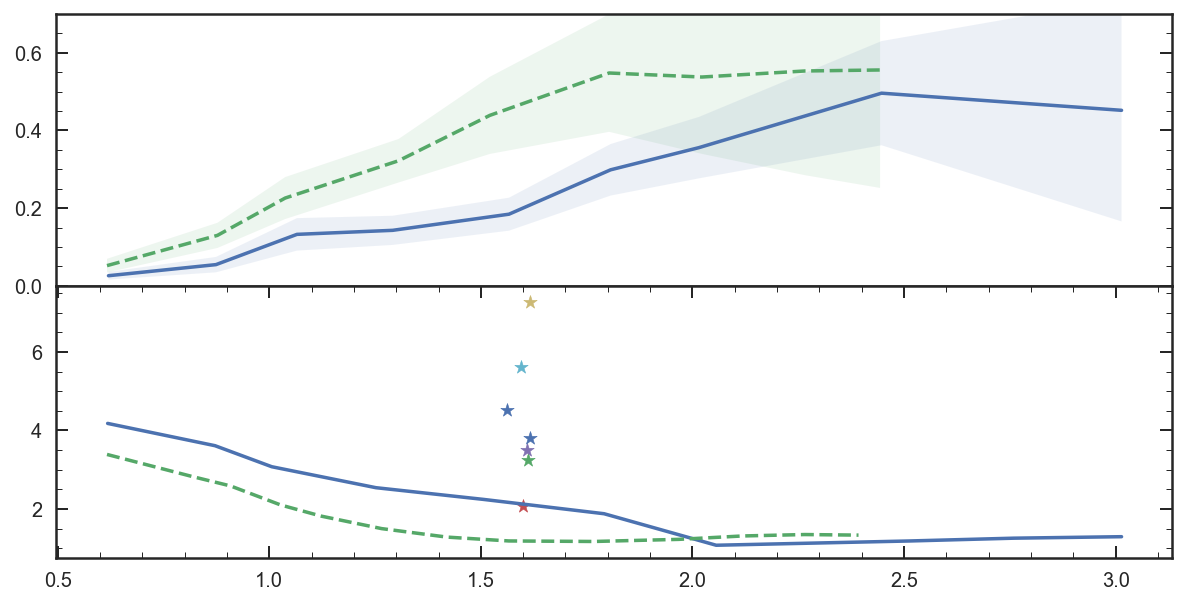

In [126]:
gs = GridSpec(2,1, hspace=0)

ige1 = interp1d(gez1,ge1)(gz1)
ige2 = interp1d(gez2,ge2)(gz2)

err1 = g1 - ige1
err2 = g2 - ige2

plt.figure(figsize=[10,5])
plt.subplot(gs[0])

plt.plot(gz1, g1)
plt.fill_between(gz1, g1 - err1, g1 + err1, alpha = 0.1)

plt.plot(gz2, g2,'--')
plt.fill_between(gz2, g2 - err2, g2 + err2, alpha = 0.1)

plt.xticks([])
plt.ylim(0,0.7)

plt.subplot(gs[1])
plt.plot(sz1, ser1)
plt.plot(sz2, ser2,'--')

for i in range(len(gals)):
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(gals[i]))
    plt.scatter(z[pz == max(pz)][0], goodss_rad.n[gals[i] - 1], marker = '*')


# plt.ylim(0,4.25)

In [33]:
dx1, dy1 = np.loadtxt('../data/plot_points/d1.csv', delimiter= ',').T
dx2, dy2 = np.loadtxt('../data/plot_points/d2.csv', delimiter= ',').T


In [36]:
Lmass = np.log10(v4S_q.mass.values)


In [37]:
10**Lmass / 1E11 * 100

array([216.74647951,  89.86193743, 163.63056923, 302.08351536,
       201.2157346 , 226.59777885])

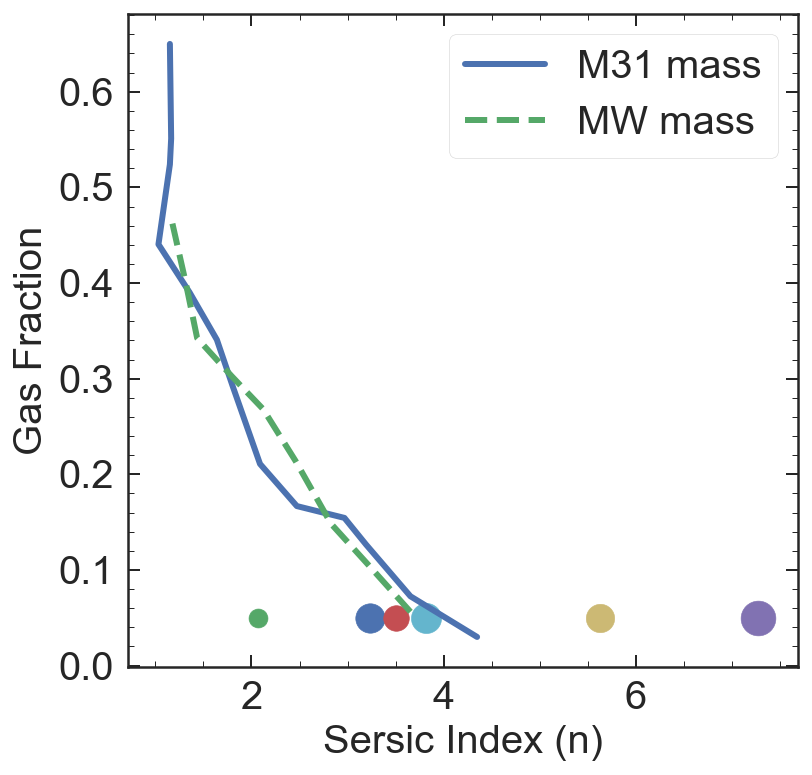

In [39]:
plt.figure(figsize=[6,6])
plt.plot(dx1,dy1, linewidth = 3, label = 'M31 mass')
plt.plot(dx2,dy2,'--', linewidth = 3, label = 'MW mass')

for i in range(len(gals)):
    plt.scatter(goodss_rad.n[gals[i] - 1],0.05, marker = 'o',s=10**Lmass[i] / 1E11 * 100)
    
plt.xlabel('Sersic Index (n)', fontsize=20)
plt.ylabel('Gas Fraction', fontsize=20)
plt.legend( fontsize=20, loc=1, frameon = True)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/ALMA/gas.png' ,bbox_inches = 'tight')


In [124]:
# for i in goodss_rad.index:
#     if goodss_rad.NUMBER[i] in gals:
#         print(goodss_rad.NUMBER[i], goodss_rad.n[i],goodss_rad.re[i] * np.sqrt(goodss_rad.q[i]))
        
for i in range(len(gals)):
    z,pz = np.load('../data/posteriors/ALMA_{0}_Pz.npy'.format(gals[i]))
    
    
    print(goodss_rad.NUMBER[gals[i] - 1], goodss_rad.n[gals[i] - 1],z[pz == max(pz)][0])#,goodss_rad.re[gals[i] - 1] * np.sqrt(goodss_rad.q[gals[i] - 1]))        

39012 4.5309 1.5608632361631087
39364 3.2361 1.6112080798277324
40223 2.0646 1.5991917243125393
41520 3.5081 1.60854213012882
42113 7.2687 1.6153183776258682
42778 5.6207 1.5937824593517413
44042 3.8145 1.6156821069173826


In [156]:
for i in range(len(gals)):
    try:
        x,px = np.load('../data/posteriors/GSD_{0}_tabfit_Pd.npy'.format(gals[i]))
        a = x[px == px.max()][0]
        print(a)
        
    except:
        print('no sfh')

no sfh
0.3565176523521626
no sfh
0.18258861262638687
0.2721189062831736
no sfh
0.7401771040551848


In [43]:
np.log10(0.5*1E9 * 170)


10.929418925714293

In [45]:
1/0.76 *0.2


0.26315789473684215

In [46]:
v4S

NameError: name 'v4S' is not defined